# Convention theory and goal of experiments
Convention theory is based on the idea that actors have different motivations for their actions but have to find some sort of common ground in order to enable economic or social transactions. The solution lies in bringing together justifications from different worlds into a formal or information convention, a negotiated agreement that structures the desired transaction. Actors work together to come to a compromise about the convention to use.
(https://www.academia.edu/2745478/Building_Quality_Building_Green_Conventions_Theory_and_Industry_Transformation)

These used conventions can simultaneously satisfy multiple justifications.


Our goal is to build a model to provide statistical estimates of the existince of the various conventions in the data to be analyzed, rather than to make automatic decisions.




In [3]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers, info = default_model_helpers_for_project()
#if you want to see the paths now can call with...
display (HTML(info))

paths = project_paths()

#same for paths and repo data, display using...
display (HTML(paths.get_paths_data()))
display (HTML(paths.get_repo_data()))

# #We could move these imports to the helper classes file
# import matplotlib.lines as mlines
# import matplotlib.transforms as mtransforms
# from sklearn.calibration import calibration_curve
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.isotonic import IsotonicRegression


Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


In [4]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# # visualization imports
# from IPython.display import display
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import base64
# import io
# sns.set() 
# sns.set_style("whitegrid")
# from sklearn.metrics import accuracy_score, auc, precision_score, roc_curve, confusion_matrix, classification_report
# import tqdm
# from sklearn.calibration import calibration_curve
# from sklearn.isotonic import IsotonicRegression


# Read the Training data and also the gathered data(to generate vocab for word embedding)

https://raw.githubusercontent.com/aideenf/AIVC/master/cp_wssc/Data/Iterative-models-building/Training%20data/Conventions/training_ALL.tsv
Data/Iterative-models-building/Training data/Conventions/training_ALL.tsv
Initialised generic_parsing_helpers class and methods


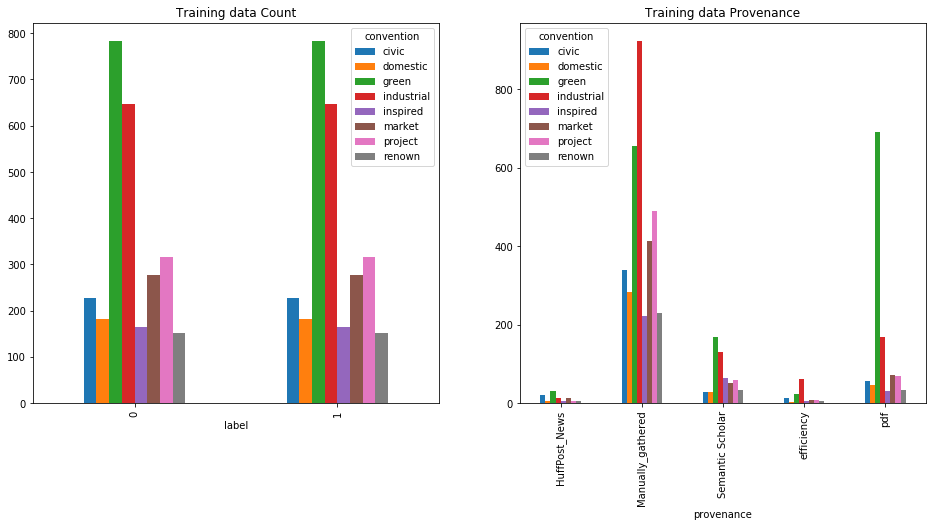

<Figure size 432x288 with 0 Axes>

In [6]:
#Read the combined original training data and audited data file from "training_ALL.tsv"
#Note this method already calls "remove_line_breaks"
USE_GIT_HUB = False

print (paths.TRAINING_DATA_ALL_DIR_FILE_GIT)
print (paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL)

#Note this method already calls "remove_line_breaks"
training_df = model_helpers.get_training_data(
                            USE_GIT_HUB,
                            paths.TRAINING_DATA_ALL_DIR_FILE_GIT,
                            paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

def display_training_data(training_df):
    training_df['text'] = training_df['text'].str.strip()
    training_df['text'] = training_df['text'].apply(aivm_helper.pre_process_sentence)
    training_df.head(5)
    display(HTML("Training Data Analysis, number of sentences per convention and per provenance"))
    count1 = widgets.HTML(value=pd.DataFrame(training_df.groupby('convention')['text'].count()).to_html())
    count2 = widgets.HTML(value=pd.DataFrame(training_df.groupby('provenance')['text'].count() ).to_html())
    display (widgets.HBox([count1, count2]))

    counts_cross_tab = pd.crosstab(training_df['label'],training_df['convention'])
    provenance_cross_tab = pd.crosstab(training_df['provenance'],training_df['convention'])

    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    axes2 = plt.subplot(1,2,2)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Training data Count")
    provenance_cross_tab.plot(ax = axes2, kind='bar', title ="Training data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()

    count1 = 0
    count2 = 0
    provenance_cross_tab = pd.DataFrame()
    gc.collect()
    
display_training_data(training_df)

Initialised AIVM_helper class and methods


,text,provenance
0,Efficiency testing tests the amount of resourc...,efficiency
1,Efficiency can be defined as using the resourc...,efficiency
2,we probably able to develop an optimal system ...,efficiency
3,If we worry about the performance only after t...,efficiency
4,Provides configurable automation of system and...,efficiency


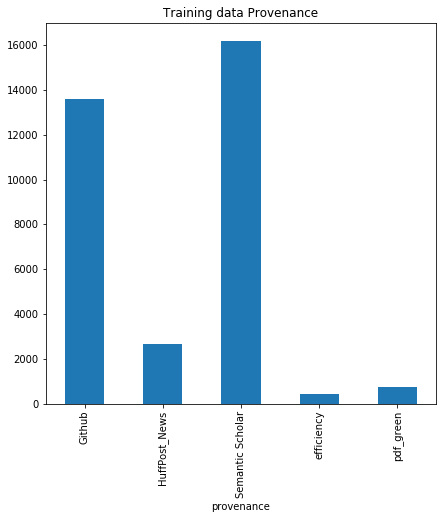

Total number of sentences: 33632


<Figure size 432x288 with 0 Axes>

In [7]:
#Note this method already processes the gathered data and reads either from local or directly from git.
gathered_conventions_files, gathered_conventions_df = model_helpers.get_aggregated_gathered_data (
                            USE_GIT_HUB,
                            paths.GATHERED_DATA_CONV_DIR_GIT,
                            paths.GATHERED_DATA_CONV_DIR_LOCAL,
                            paths.GITHUB_GATHERED_URL_PATH, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

def display_gathered_data(gathered_conventions_df):
    gathered_conventions_df['text'] = gathered_conventions_df['text'].str.strip()
    gathered_conventions_df['text'] = gathered_conventions_df['text'].apply(aivm_helper.pre_process_sentence)
    display(HTML("Gathered data"))
    display (gathered_conventions_df.head(5))
    count = widgets.HTML(value=pd.DataFrame(gathered_conventions_df.groupby('provenance')['text'].count() ).to_html())
    display (widgets.HBox([count]))

    fig = plt.figure(figsize=(8,8))
    gathered_conventions_df.groupby('provenance')['text'].count().plot(kind='bar', figsize=(7,7), title ="Training data Provenance")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()
    count = 0
    print ("Total number of sentences:",gathered_conventions_df.shape[0] )

display_gathered_data(gathered_conventions_df)

# Train the DL Models
A multi-label classifier assigns a set of labels to each sentence. The simplest multi-label classifier, called Binary Relevance (BR), applies one binary classifier to each label(convention) independently and takes the product of the individual label probabilities as the overall label-set probability (confidence). Despite its many known drawbacks, such as generating suboptimal predictions and poorly calibrated confidence scores, BR is widely used in practice due to its speed and simplicity.[ Tsoumakas, G., Katakis, I.: Multi-label classification: An overview. Int J Data Warehousing and Mining 2007, 1–13 (2007)]

As this problem is multi-label and multi class the overall solution is a one v's all, Binary Relevance approach.

In [8]:
## Train DL models
## Vocabulary loading
def _read_glove_embeddings(glove_dir, embedding_dim):
    print ("Reading word embedding from:", os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    ## Reading GLOVE (precalculated word embeddings)
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.{}d.txt'.format(embedding_dim)))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index



def train_models(gathered_conventions_df, training_df):
    """
    N=1
    models = []
    for i in range(N):
        result = model_helpers.train_DL_models(training_df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True) 
        models.append(result)
    
    """
    embeddings_index =_read_glove_embeddings(glove_dir=paths.GLOVE_DIR_LOCAL, embedding_dim=model_helpers.EMBEDDING_DIM)
    print ("Embeddings:", type(embeddings_index))
    column_to_tokenize = 'text'
    gathered_and_training = pd.DataFrame(gathered_conventions_df[column_to_tokenize].append(training_df[column_to_tokenize]))##Adding training data sentences
    extended_tokenizer = parsing_helpers.create_tokenizer(gathered_and_training, 
                                                            column_to_tokenize,
                                                          max_words=model_helpers.MAX_NB_WORDS)


    print ("Tokenizer:", type(extended_tokenizer))

    _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_x_txt, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(training_df,
                    embeddings_index,                                                                                                             
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True
                    ) 
                

        #not used therefor releasing memory. 
    _DLTokenizers = 0
    _DLTrain_histories = 0
    gathered_conventions_files = 0
    gathered_conventions_df = 0
    gathered_and_training = 0
    extended_tokenizer = 0


    gc.collect()
    return _DLModels, _DLData_val_x, _DLData_val_x_txt, _DLData_val_y

_DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y = train_models(gathered_conventions_df, training_df)

#Release the memory as not used after this point. 
gathered_conventions_df = pd.DataFrame()


Reading word embedding from: Data/Iterative-models-building/Training data/glove.6B.100d.txt
Embeddings: <class 'dict'>
Tokenizer: <class 'keras_preprocessing.text.Tokenizer'>
Found 76203 unique tokens.
----------------------------------------------------------------
            civic                  
----------------------------------------------------------------
Shape of data tensor: (456, 32)
Shape of label tensor: (456, 2)

Number of elements from each class in traing and validation set 
[181. 184.]
[47. 44.]


/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 100)      7620400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 30, 128)      38528       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 29, 128)      51328       embedding_1[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 100)      7620400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 30, 128)      38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 29, 128)      51328       embedding_2[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 100)      7620400     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 30, 128)      38528       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 29, 128)      51328       embedding_3[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 32, 100)      7620400     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 30, 128)      38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 29, 128)      51328       embedding_4[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 32, 100)      7620400     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 30, 128)      38528       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 29, 128)      51328       embedding_5[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 32, 100)      7620400     input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 30, 128)      38528       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 29, 128)      51328       embedding_6[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 32, 100)      7620400     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 30, 128)      38528       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 29, 128)      51328       embedding_7[0][0]                
__________________________________

/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 32, 100)      7620400     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 30, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 29, 128)      51328       embedding_8[0][0]                
__________________________________

# Binary Relevance architecture

In [ ]:
url = 'https://github.com/aideenf/AIVC/raw/master/cp_wssc/Drawings/models.png'
r = req.get(url)
display (PIL_Img.open(BytesIO(r.content)))

# Methods used by various steps

In [9]:
def get_positive_preds_with_threshold(preds, threshold=0.5):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #ie 
    preds_results = []
    for j in range(len(preds)):
        #int_pred = int(preds[j][1]>=threshold)
        int_pred = int(preds[j]>=threshold)
        preds_results.append(int_pred)
    return preds_results

def get_positive_preds_probabilities(preds):
    #Keras .predict returns a list of [x, y] values where x = probability of 0 and y is probability of 1
    #i.e preds[j][1] is the probability of a positive prediction.
    preds_results = []
    for j in range(len(preds)):
        int_pred = preds[j][1]
        preds_results.append(int_pred)    
    return preds_results

def apply_pred_threshold(preds, t):
    res = np.zeros(len(preds))  
    res[preds>=t] = 1
    return res

def calculate_metrics(results, num_samples, model):
    
    results.insert(0,'index', range(0,results.shape[0]))
    metrics_df = pd.DataFrame(index = results['index'], columns=['model','threshold','accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])

    for i in results.iterrows():
        
        index, threshold, tp, fp, tn, fn = i[1]

        assert tp + fp + tn + fn == num_samples 
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
            f2 = 0
            f0_5 = 0
            
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
            f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
        false_positive_rate = fp / (fp + tn)
        
        accuracy = (tp+tn)/(tp + fp + tn + fn)
        specifity = tn / (tn + fp)
        
        metrics_df.loc[index, 'model'] = model
        metrics_df.loc[index, 'accuracy'] = accuracy
        metrics_df.loc[index, 'precision_ppv'] = precision
        metrics_df.loc[index, 'recall_sensitivity_tpr'] = recall
        metrics_df.loc[index, 'f1'] = f1
        metrics_df.loc[index, 'f2'] = f2
        metrics_df.loc[index, 'f0_5'] = f0_5
        metrics_df.loc[index, 'specifity_selectivity_tnr'] = specifity
        metrics_df.loc[index, 'tpr'] = true_positive_rate
        metrics_df.loc[index, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
    metrics_df = pd.concat([results, metrics_df.drop("threshold", axis=1)],axis=1, join='inner', sort = False)
    metrics_df = metrics_df.drop("index", axis=1)
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    return metrics_df


def calculate_full_set_micro_average(results):
    
    metrics_df = pd.DataFrame(columns=['model','threshold','tp', 'fp', 'tn', 'fn', 'accuracy', 'precision_ppv', 'recall_sensitivity_tpr', 'f1', 'f2', 'f0_5','specifity_selectivity_tnr', 'tpr', 'fpr'])    
    tp =  results[0]
    fp =  results[1]
    tn =  results[2]
    fn =  results[3]
  
    recall = tp / (tp + fn)
        
    if tp == fp == 0:
        precision = 0
        true_positive_rate = 0
        
    else:
        precision = tp / (tp + fp)
        true_positive_rate = tp / (tp + fn)
            
    if precision == recall == 0:
        f1 = 0
        f2 = 0
        f0_5 = 0
            
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f2 = (2*2 + 1)*precision*recall / (2*2*precision + recall)#weights recall higher than precision, and 
        f0_5  = (.5*.5 + 1)*precision*recall /(.5*.5*precision + recall)#puts more emphasis on precision than recall.

        
    false_positive_rate = fp / (fp + tn)
        
    accuracy = (tp+tn)/(tp + fp + tn + fn)
    specifity = tn / (tn + fp)
    

    metrics_df.loc[0, 'model'] = "set_micro_average"
    metrics_df.loc[0, 'threshold'] = "NaN"
    metrics_df.loc[0, 'tp'] = tp
    metrics_df.loc[0, 'fp'] = fp
    metrics_df.loc[0, 'tn'] = tn
    metrics_df.loc[0, 'fn'] = fn
    metrics_df.loc[0, 'accuracy'] = accuracy
    metrics_df.loc[0, 'precision_ppv'] = precision
    metrics_df.loc[0, 'recall_sensitivity_tpr'] = recall
    metrics_df.loc[0, 'f1'] = f1
    metrics_df.loc[0, 'f2'] = f2
    metrics_df.loc[0, 'f0_5'] = f0_5
    metrics_df.loc[0, 'specifity_selectivity_tnr'] = specifity
    metrics_df.loc[0, 'tpr'] = true_positive_rate
    metrics_df.loc[0, 'fpr'] = false_positive_rate  #inverse recall    
    metrics_df.reset_index()
   
    
    #set the model name to col 0 for consistency
    model = metrics_df.pop('model')
    metrics_df.insert(0, 'model', model)
    
    return metrics_df

def get_validation_data_for_stats(_DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y ):
    
    column_list = []
    column_list.append("text")
    column_list.append("convention")
    column_list.append("label")
    for conv in _DLModels.keys():
        column_list.append(conv)
    all_validation_df = pd.DataFrame(columns=column_list)
    validation_df = pd.DataFrame(columns=column_list)
    
   
    for conv in _DLModels.keys():
        validation_df = pd.DataFrame(columns=column_list)
        data_x = _DLData_val_x_txt_seq[conv]
        data_x_txt = _DLData_val_x_txt [conv] 
        y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[conv]]
        validation_df['text'] = data_x_txt
        validation_df['convention'] = conv
        validation_df['label'] = y_actual
        validation_df[conv] = y_actual
        all_validation_df = pd.concat([all_validation_df, validation_df], sort = False )  
    #add the number of labels per sentence with and without calibration    
    #Check for and remove duplicate rows and duplicate sentences.                                 
    print ("Number of unique strings", len(all_validation_df['text'].unique()))
    print ("Length of data frame", len(all_validation_df.index))
    print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    print ("Dropping duplicate rows")
    all_validation_df = all_validation_df.drop_duplicates(keep = "first")
    all_validation_df = all_validation_df.groupby(['text'], as_index=False).max()
    print ("Number of unique strings after drop", len(all_validation_df['text'].unique()))
    print ("Length of data frame after drop", len(all_validation_df.index))
    print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    #print ("Length of data frame after drop NaN", len(df.index))
    return all_validation_df.fillna(0)

#Here we get the validation data per model, predict a score with that model A 
#then predict a score with the x_validation data of model A against all 7 other models.






def get_validation_data(thresholds, _DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y):
    column_list = []
    column_list.append("text")
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
    all_validation_df = pd.DataFrame(columns=column_list)
    validation_df = pd.DataFrame(columns=column_list)
    
    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####
    
    for conv in _DLModels.keys():
        validation_df = pd.DataFrame(columns=column_list)
        data_x = _DLData_val_x_txt_seq[conv]
        data_x_txt = _DLData_val_x_txt [conv] 
        y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[conv]]
        
        conv_model = _DLModels[conv]        
        conv_ir = _DLModelsIsotonicRegression[conv]
        
        #First through our model then the output is scaled with the Isotonic Regression predict.
        y_predict = conv_model.predict(data_x)
        y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
        y_predict_isotonic_prob = conv_ir.predict(y_pos_predict_prob)
        
        #y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[conv])
        y_pred_iso = get_positive_preds_with_threshold(y_predict_isotonic_prob, thresholds[conv])
        
        validation_df['text'] = data_x_txt
        validation_df[conv] = y_actual
        
        #if y_pred_iso = 1 then prob = y_predict_isotonic_prob
        #if y_pred_iso = 0 then prob = 1 - y_predict_isotonic_prob
        #in otherwords this is the probability of the y_predict
        validation_df[conv+"_prob"] = sub_funct_get_prob(y_predict_isotonic_prob, y_pred_iso)
        #validation_df[conv+"_prob"] = y_predict_isotonic_prob
        validation_df[conv+"_y_pred"] = y_pred_iso
        validation_df[conv+"_prob_1"] = y_predict_isotonic_prob
    
        #Now put these validation sentences through all the other models.
        all_models = list(_DLModels.keys())
        all_other_models = all_models
        all_other_models.remove(conv)
        for model in all_other_models:
            other_model = _DLModels[model]        
            other_ir = _DLModelsIsotonicRegression[model]
            y_predict = other_model.predict(data_x)
            y_pos_predict_prob = get_positive_preds_probabilities(y_predict)
            y_predict_isotonic_prob = other_ir.predict(y_pos_predict_prob)
            #y_pred = get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
            y_pred_iso = get_positive_preds_with_threshold(y_predict_isotonic_prob, thresholds[model])
            validation_df[model] = 0
            validation_df[model+"_prob"] =  sub_funct_get_prob(y_predict_isotonic_prob, y_pred_iso)
            #validation_df[model+"_prob"] = y_predict_isotonic_prob
            validation_df[model+"_y_pred"] = y_pred_iso
            validation_df[model+"_prob_1"] = y_predict_isotonic_prob
        all_validation_df = pd.concat([all_validation_df, validation_df], sort = False )  
    #add the number of labels per sentence with and without calibration
    y_pred_list = []
    for x in all_validation_df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
    prob_list = []
    conv_list = []
    for x in all_validation_df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
           
    pred_sums = all_validation_df[y_pred_list].sum(axis=1)
    all_validation_df['lbl_cnt'] = pred_sums
    
    prob_product= all_validation_df[prob_list].prod(axis=1)
    all_validation_df['set_conf'] = prob_product
    
    positive_sample = all_validation_df[conv_list].sum(axis=1)
    all_validation_df['pos_sample'] = positive_sample
    
    #Check for and remove duplicate rows and duplicate sentences.                                 
    print ("Number of unique strings", len(all_validation_df['text'].unique()))
    print ("Length of data frame", len(all_validation_df.index))
    print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    print ("Dropping duplicate rows")
    all_validation_df = all_validation_df.drop_duplicates(keep = "first")
    all_validation_df = all_validation_df.groupby(['text'], as_index=False).max()
    print ("Number of unique strings after drop", len(all_validation_df['text'].unique()))
    print ("Length of data frame after drop", len(all_validation_df.index))
    print ("Num Dupes:", len(all_validation_df.index) - len(all_validation_df['text'].unique()) )
    #print ("Length of data frame after drop NaN", len(df.index))
    return all_validation_df


# Review the validation data

Number of unique strings 976
Length of data frame 1096
Num Dupes: 120
Dropping duplicate rows
Number of unique strings after drop 976
Length of data frame after drop 976
Num Dupes: 0


,text,convention,label,civic,domestic,green,industrial,inspired,market,project,renown
0,' our 'deep desire for autonomy and self relia...,project,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,'in place of the traditional contract which gu...,green,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,() We introduce a class of reduced summaries.,industrial,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,() can you help me restore my purchase?,market,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,(including but not limited to procurement of s...,green,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


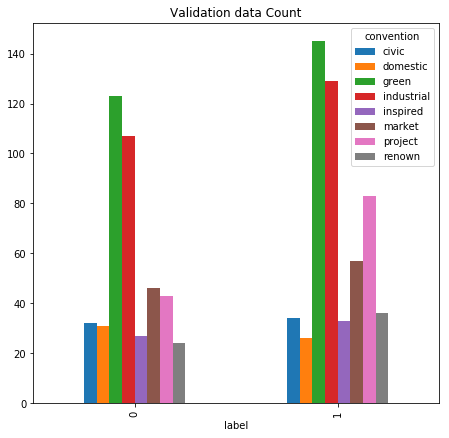

<Figure size 432x288 with 0 Axes>

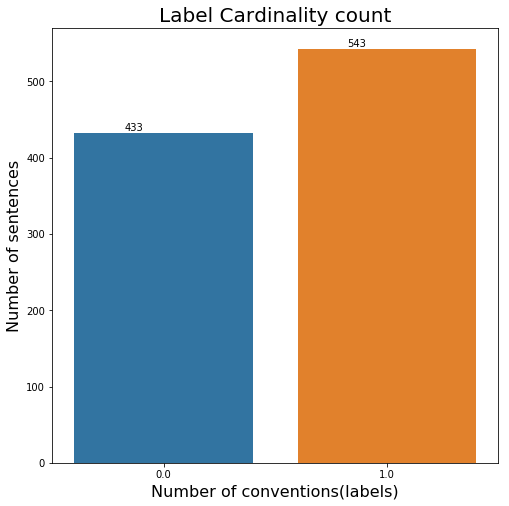

In [10]:
def display_validation_data(validation_df):
    display(validation_df.head(5))
    display(HTML("Validation Data Analysis, number of sentences per convention"))
    count1 = widgets.HTML(value=pd.DataFrame(validation_df.groupby(['convention','label'])['text'].count()).to_html())
    display (widgets.HBox([count1]))
    
    
    counts_cross_tab = pd.crosstab(validation_df['label'],validation_df['convention'])
    
    fig = plt.figure(figsize=(16,7))
    axes1 = plt.subplot(1,2,1)
    counts_cross_tab.plot(ax = axes1, kind='bar', title ="Validation data Count")
    plt.show()
    _ = plt.close(fig)
    _ = plt.clf()

    
    model_helpers.label_cardinality_bar(validation_df.drop("convention", axis=1).drop("label", axis=1).drop("text", axis=1))
    gc.collect()
display_validation_data(get_validation_data_for_stats(_DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y ))

# Calibration of individual model confidence (Re-scaling operation) - The probability associated with the predicted class label should reflect its ground truth correctness likelihood. log-loss optimization

Now we have our simple multi-label "Binary Relevance(BR)" classifier i.e  one binary classifier for each of our 8 labels(conventions). BR has two well-known drawbacks. First, BR neglects label dependencies and this often leads to prediction errors: some BR predictions are incomplete, eg. tagging cat but not animal for an image, and some are conflicting, such as predicting both the code "Pain in left knee" and the code "Pain in unspecified knee" for a medical note." In our case there are no label dependencies(no convention dependencies) so this drawback is not an issue.

The second drawback is that the overall set is often not well calibrated. In order for the overall set to be well calibrated the first task will be to ensure that each individula model is well calibrated. A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions. The established procedures are isotonic regression or Platt scaling) "In machine learning, Platt scaling or Platt calibration is a way of transforming the outputs of a classification model into a probability distribution over classes. The method was invented by John Platt in the context of  support vector machines, replacing an earlier method by Vapnik, but can be applied to other classification models. Platt scaling works by fitting a logistic regression model to a classifier's scores." Isotonic regression has been shown to work better than Platt scaling, in particular when enough training data is available. Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. The only difference lies in the function being fit. The function we fit in isotonic regression continuously increases/decreases.  

So at this point the overall system is predicting  the probability that a sentence belonging 
to each of the eight conventions.  In general, the distribution of these probabilities per classifier may 
not match the expected distribution of observed probabilities. The distribution of the probabilities is therefor calibrated(or adjusted) to better match the expected distribution observed in the data. As mentioned this adjustment is a rescaling operation applied after the predictions have been made by the models. This calibration or scaling can be achieved by using for example, Platt Scaling or Isotonic Regression.


A probabilistic model is well calibrated if for example when we 'bin' the test samples based on their predicted probabilities and when we then examine each bin’s true outcomes, the true outcome should have a proportion close to the probabilities in the bin.  If we predict that we are 99% sure, and if we are only right 50% of the time, this is not calibrated because our estimation was too optimistic. Similarly, if we predict that we are only 60% sure, and we are right 80% of the time, this is not calibrated because our estimation was too pessimistic.

If we split our probability 0 to 1 into 10 bins (0-0.1, 0.1-0.2,.... 0.8 to 1) then in the .8 bin 80% of the predictions should in theory be correct(based on true outcomes) as this would basically imply an 80% confidence rating. This information can be reflected in a reliability diagram(or calibration plot). Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

NOTE: For each bin, the mean predicted value is plotted against the true fraction of positive cases. If the model is well calibrated the points will fall near the diagonal line.

below we plot the reliability diagram for each of our 8 models, against a version calibrated with isotonic regression. 

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.5416143846853599
* log loss(cross entropy) with calibration:  0.31591538220783777

* Brier score(MSE) without calibration:  0.12008612689149104
* Brier score(MSE) with calibration:  0.09449333735048018

* ROC AUC score without calibration:  0.9028046421663443
* ROC AUC score with calibration:  0.9250483558994197


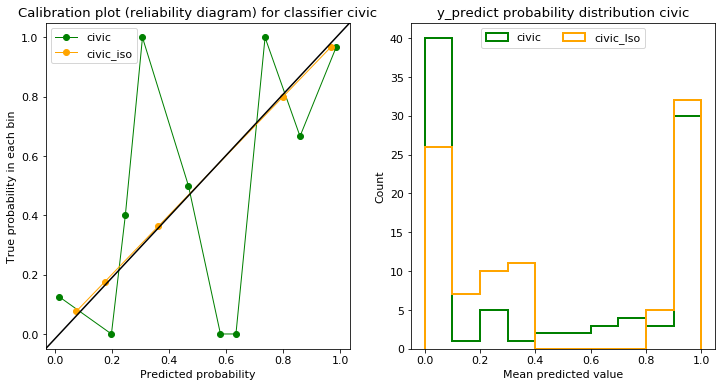

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.50132941831336
* log loss(cross entropy) with calibration:  0.29554178140638615

* Brier score(MSE) without calibration:  0.13275683340926137
* Brier score(MSE) with calibration:  0.09633838383838383

* ROC AUC score without calibration:  0.9199689199689199
* ROC AUC score with calibration:  0.939005439005439


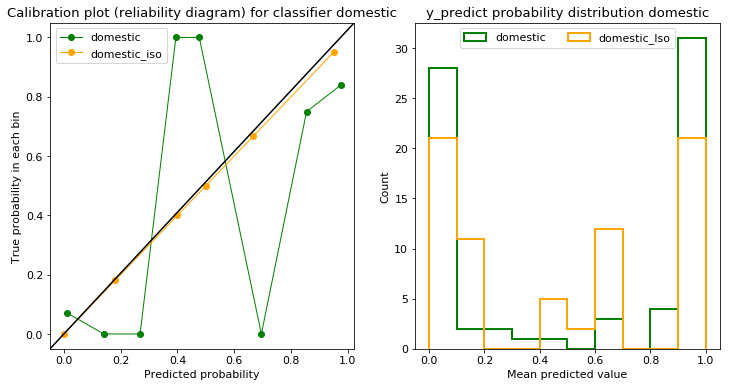

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.39035429220810086
* log loss(cross entropy) with calibration:  0.14057278854346184

* Brier score(MSE) without calibration:  0.054281679035230665
* Brier score(MSE) with calibration:  0.04113161881228331

* ROC AUC score without calibration:  0.9808870374908111
* ROC AUC score with calibration:  0.9846647063628196


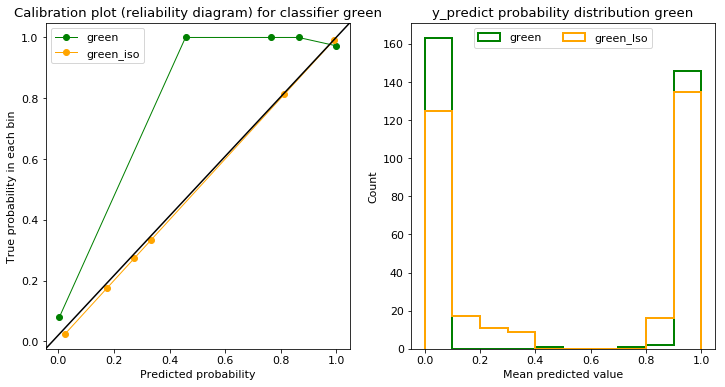

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.73982309726648
* log loss(cross entropy) with calibration:  0.35933433889374206

* Brier score(MSE) without calibration:  0.13775484424483764
* Brier score(MSE) with calibration:  0.11193089807954673

* ROC AUC score without calibration:  0.9067761194029851
* ROC AUC score with calibration:  0.9164776119402984


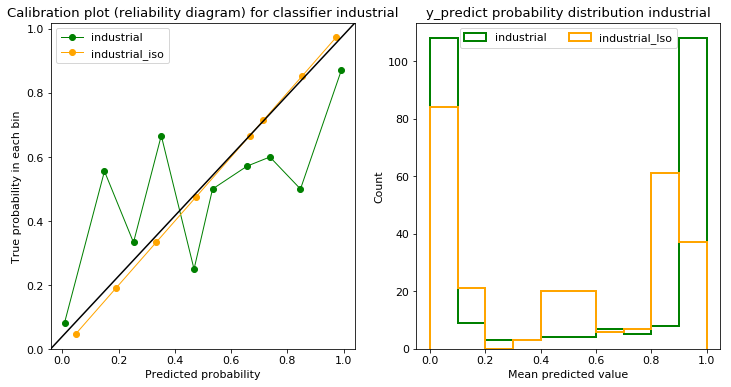

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.6505708948888171
* log loss(cross entropy) with calibration:  0.38374300072360207

* Brier score(MSE) without calibration:  0.20726983173696595
* Brier score(MSE) with calibration:  0.13130715438407747

* ROC AUC score without calibration:  0.8544061302681992
* ROC AUC score with calibration:  0.8845785440613027


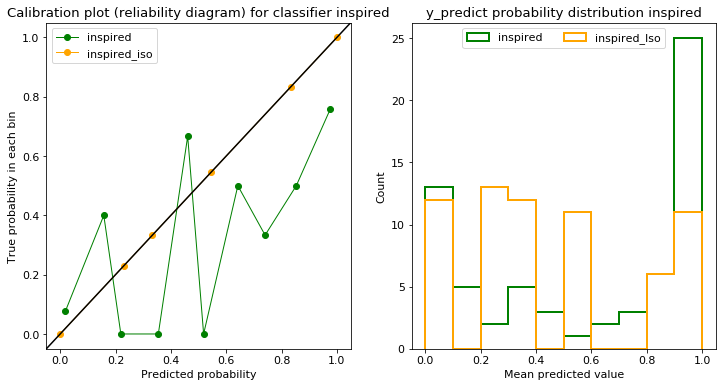

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.42859762054504247
* log loss(cross entropy) with calibration:  0.30899572092264377

* Brier score(MSE) without calibration:  0.12409311694947421
* Brier score(MSE) with calibration:  0.10106375383736706

* ROC AUC score without calibration:  0.91005291005291
* ROC AUC score with calibration:  0.9279100529100529


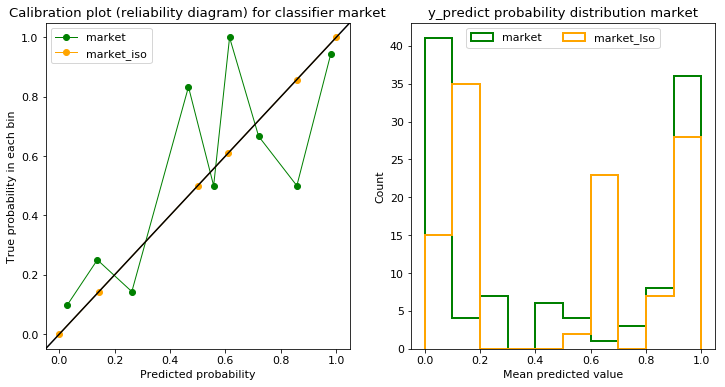

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.6446599163286414
* log loss(cross entropy) with calibration:  0.40866518508691974

* Brier score(MSE) without calibration:  0.16325601401348977
* Brier score(MSE) with calibration:  0.1284471701138368

* ROC AUC score without calibration:  0.8323979591836734
* ROC AUC score with calibration:  0.8602040816326532


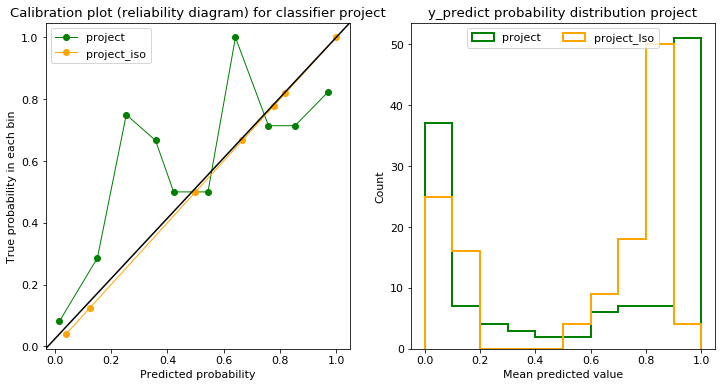

Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
* log loss(cross entropy) without calibration:  0.48151623798379056
* log loss(cross entropy) with calibration:  0.36959679089949343

* Brier score(MSE) without calibration:  0.15020887010187436
* Brier score(MSE) with calibration:  0.12162698412698414

* ROC AUC score without calibration:  0.8754171301446052
* ROC AUC score with calibration:  0.8993325917686319


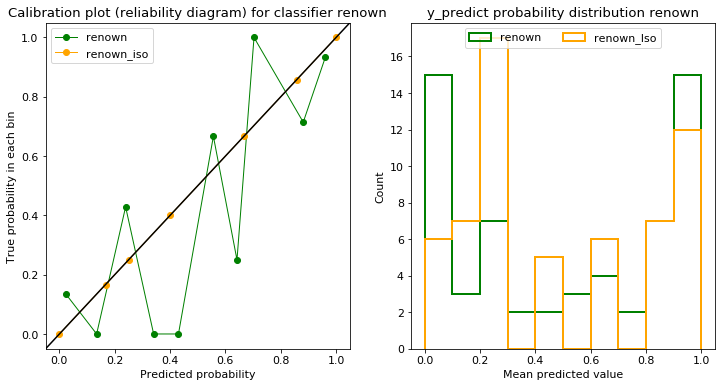

37662

<Figure size 432x288 with 0 Axes>

In [11]:
display (HTML ("<font color = 'green'><h3><left>Calibration plot generated via sklearn.calibration.calibration_curve <br/> Isotonic calibration applied using sklearn.isotonic.IsotonicRegression</left></h3></font>"))
display (HTML ("Isotonic Regression is similar to Platt Scaling. It’s a non-parametric regression technique. Non-parametric means that it doesn’t make any assumptions such as of linearity among variables, constant error variance etc. Note that calibration will not improve accuracy but rather will improve log-loss. The goal of our machine learning models is to minimize this value. A perfect model would have a log loss of 0."))

_DLModelsIsotonicRegression = {}
for convention in _DLModels.keys():
    display (HTML ("<font color = 'green'><h3><left>" + convention + "</left></h3></font>"))
    _DLModelsIsotonicRegression[convention] = IsotonicRegression(out_of_bounds = 'clip')
    #get the model, the validation data input(my_data_x) and the predicted label(preds) to compare to the actual label(y_actual).
    model = _DLModels[convention]
    data_x = _DLData_val_x_txt_seq[convention]
    
    y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[convention]]
    y_predict = model.predict(data_x)
    y_predict = get_positive_preds_probabilities(y_predict)
    
    _DLModelsIsotonicRegression[convention].fit(y_predict, y_actual)
    y_predict_isotonic = _DLModelsIsotonicRegression[convention].predict(y_predict)
    log_loss_before = log_loss(y_actual , y_predict, eps = 1e-7)
    log_loss_after = log_loss(y_actual , y_predict_isotonic, eps = 1e-7 )
    brier_score_before = brier_score_loss(y_actual , y_predict)
    brier_score_after = brier_score_loss(y_actual , y_predict_isotonic)
    roc_auc_score_before = roc_auc_score(y_actual , y_predict)
    roc_auc_score_after = roc_auc_score(y_actual , y_predict_isotonic)
    #Plot the calibration curves for test data which is not callibrated and test data which is callibrated
    y, x = calibration_curve(y_actual, y_predict, n_bins=10);
    y_iso, x_iso = calibration_curve(y_actual, y_predict_isotonic, n_bins=10);
    print ("Information on metrics https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/")
    print ("* log loss(cross entropy) without calibration: ", log_loss_before)
    print ("* log loss(cross entropy) with calibration: ", log_loss_after)
    print ("")
    print ("* Brier score(MSE) without calibration: ", brier_score_before)
    print ("* Brier score(MSE) with calibration: ", brier_score_after)
    print ("")
    print ("* ROC AUC score without calibration: ", roc_auc_score_before)
    print ("* ROC AUC score with calibration: ", roc_auc_score_after)
    
    _ = plt.figure(figsize=(12,6))
    _ = plt.rcParams.update({'font.size': 11})
    _ = plt.rcParams.update({'font.weight': 'normal'})


    ax = plt.subplot(1, 2, 1)
    # only these two lines are calibration curves
    _ = plt.plot(x, y, marker='o', linewidth=1, label=convention, color='green');
    _ = plt.plot(x_iso, y_iso, marker='o', linewidth=1, label=convention+'_iso', color='orange');

    # reference line, legends, and axis labels
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    _ = line.set_transform(transform)
    _ = ax.add_line(line)
    ax.set_title ('Calibration plot (reliability diagram) for classifier ' + convention) 
    _ = ax.set_xlabel('Predicted probability')
    _ = ax.set_ylabel('True probability in each bin')
    _ = plt.legend()

    

    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title ('y_predict probability distribution ' + convention) 
    _ = ax2.hist(y_predict, range=(0, 1), bins=10, label=convention,
                 histtype="step", lw=2, color = "green")
    _ = ax2.hist(y_predict_isotonic, range=(0, 1), bins=10, label=convention +'_Iso',
                 histtype="step", lw=2, color = "orange")
    _ = ax2.set_xlabel("Mean predicted value")
    _ = ax2.set_ylabel("Count")
    _ = ax2.legend(loc="upper center", ncol=2)
    
    plt.show()
plt.clf()
gc.collect()

# Metrics to help select probability threshold
We should review individual model performance and model overall set performane to determine which confidence/probability thresholds to use for the individual models in order to produce the best overall set performance.


What is the treshold? Each of our models will return the Probability of a sentence belonging to the convention represented by the model. Now this probability needs to be turned into a Classification.
    - Belongs to the convention (Class 1)
    - Does not belong to the convention (Class 0)

we could say that this classification should occur at probability 0.5 however this may not be the best place to put it and for performance of our overall system this "threshold" may vary per model. We will therefor evaluate each individual models performance for a number of performance matrics, for a selection of different classification thresholds, in order to ultimately determine what Threshold  per model to use on unseen data once the model is live.

First we should review metrics for each individual model. In this case our training and evaluation data for each model is very balanced, in that we have an equal amount of Class 1 and Class 0 training sets per model. This balance has been achieved by data resampling either under-sampling the majority of the class, or over-sampling the minority class, or a mix of both(depending on which of the 8 models is in question). This is something to consider when ultimitely deciding the metric to base our threshold decisions on per model (but we should also keep in mind the overall system and the distribution of conventions in unseen(real world) data. 

The Metrics to evaluate:
    * Where Class 1 = Sentence belongs to Convention
    * Where Class 0 = Sentence does not belongs to Convention
 We evaluate against against a gold standard (or the ‘ground truth’ as it is perceived) i.e the true values v's the models predicted valuse in our test/validation data set. 

//////////////////////////////////////////*ACCURACY*/////////////////////////////////////////////////////////////

    - Accuracy = (TP + TN)/(TP + FP + TN + FN)

The probability that the classification result is correct, ie probability of correctly labeling sentences as class 1 or Class 0, given all the sentences!

Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Accuracy is a good measure  for well balanced datasets and when false negatives & false positive predictions have a similar 'costs'.

With imbalanced data, for example containing a lower amount of Class 1 compared to Class 0,  proclaiming all sentences as class 0 will have quite a high accuracy due to the low overall presence of Class 1, this may not ultimately be a helpful metric though if the cost of a false negative(false class 0) has a high cost. In the case of each of our individual models, our training data is quite balanced and there is a similar cost for FP and FN. however we need to keep in mind that the overall distribution of data in our overall system is not so evenly distributed across the labels that each model represents. 


////////////////////////////*PRECISION/POSITIVE PREDICTION VALUE*//////////////////////////////////////////////

     - Precision or Positive prediction value =  TP / (TP + FP)
     
The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. eg in green model, the probability that a sentenced classified as positive(1) for green, is actually green. 

Our focus then in terms of performance might be on identifying the actually positive cases, i.e to maximize the "precision".  Although a model with umbalanced data could also 'cheat' and maximize this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity. 

   
//////////////////////////////*RECALL/SENSITIVITY/TRUE POSITIVE RATE*/////////////////////////////////////////
 
     - Recall or Sensitivity or TPR =  TP / (TP + FN)
     
Given the sentence is part of the convention, how likely is it that the classification will be positive?

Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximize the "recall" or "sensitivity". Although a model could also 'cheat' and maximize this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity. 

//////////////////////////////*SPECIFITY/TRUE NEGATIVE RATE*//////////////////////////////////////////////////   

    - Specifity or TNR = TN / (TN + FP)

How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can 'cheat' and maximize this by always returning “negative”/Class 0.


///////////////////////////////////*F1, F2 and F0.5 SCORE*////////////////////////////////////////////////

    - F1 =  2 * ( (Precision * Recall) / (Precision + Recall) )
If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F1 score, this is the 'harmonic mean' of precision and recall (harmonic mean is used as it punishes extreme values)

Note: there are other F measures:
F2 which weights recall higher than precision
F0.5 which puts more emphasis on precision than recall.

Fx = (1 + x^2) * ( (precision * recall) / (x^2 *(Precision + Recall)) 


///////////////////////////////////////////////////////////////////////////////////////////////////////////   

It is importalt to look at all relevant metrics instead of just one and to make a decision based on the problem to be resolved (the purpose of the classifier and the importance/impact of incorrectly classifying as positive vs' incorrectly classifying as negative for example it is worse to falsely imprison an innocent person than to let a guilty criminal get away, however the cost attached to FP's and FN'S in our sentence classification is of a different nature. 

    -ROC Curves summarize the trade-off between the true positive rate(recall) and false positive rate for a predictive model. AUC exists independently of a threshold, whereas accuracy / precision / recall / F1-score DO require the picking of a threshold, so we are measuring two different things.

    -Precision-Recall curves summarize the trade-off between the recall(true positive rate) and the Precision(positive predictive value) for a predictive model using different probability thresholds.

Note: ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.


     -Log Loss: This Evaluation Metric is employed in the classification tasks where rather than predicting the actual classes, one needs to predict the probabilities corresponding to that classes. So, in a way this metric measures the quality of predictions rather than the accuracy.

Metrics for civic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,civic,0.0,44,47,0,0,0.483516,0.483516,1,0.651852,0.82397,0.539216,0,1,1
1,civic,0.1,42,23,24,2,0.725275,0.646154,0.954545,0.770642,0.871369,0.690789,0.510638,0.954545,0.489362
2,civic,0.2,41,17,30,3,0.78022,0.706897,0.931818,0.803922,0.876068,0.742754,0.638298,0.931818,0.361702
3,civic,0.3,39,9,38,5,0.846154,0.8125,0.886364,0.847826,0.870536,0.826271,0.808511,0.886364,0.191489
4,civic,0.4,35,2,45,9,0.879121,0.945946,0.795455,0.864198,0.821596,0.911458,0.957447,0.795455,0.0425532
5,civic,0.5,35,2,45,9,0.879121,0.945946,0.795455,0.864198,0.821596,0.911458,0.957447,0.795455,0.0425532
6,civic,0.6,35,2,45,9,0.879121,0.945946,0.795455,0.864198,0.821596,0.911458,0.957447,0.795455,0.0425532
7,civic,0.7,35,2,45,9,0.879121,0.945946,0.795455,0.864198,0.821596,0.911458,0.957447,0.795455,0.0425532
8,civic,0.8,35,2,45,9,0.879121,0.945946,0.795455,0.864198,0.821596,0.911458,0.957447,0.795455,0.0425532
9,civic,0.9,31,1,46,13,0.846154,0.96875,0.704545,0.815789,0.745192,0.901163,0.978723,0.704545,0.0212766


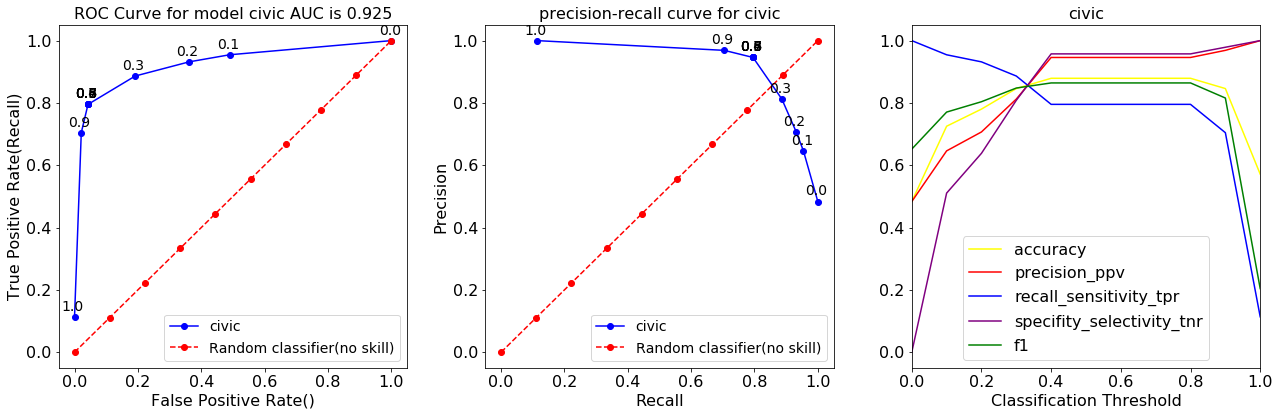

Max evaluation metric for model civic
* Accuracy:  0.8791208791208791 at threshold  0.4
* Precision:  1.0 at threshold  1.0
* Recall:  1.0 at threshold  0.0
* F1:  0.8641975308641975 at threshold  0.4
* ROC-AUC 0.925
* Log Loss 0.31591538220783777



Metrics for domestic per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,domestic,0.0,33,39,0,0,0.458333,0.458333,1,0.628571,0.808824,0.514019,0,1,1
1,domestic,0.1,33,18,21,0,0.75,0.647059,1,0.785714,0.901639,0.696203,0.538462,1,0.461538
2,domestic,0.2,31,9,30,2,0.847222,0.775,0.939394,0.849315,0.901163,0.803109,0.769231,0.939394,0.230769
3,domestic,0.3,31,9,30,2,0.847222,0.775,0.939394,0.849315,0.901163,0.803109,0.769231,0.939394,0.230769
4,domestic,0.4,31,9,30,2,0.847222,0.775,0.939394,0.849315,0.901163,0.803109,0.769231,0.939394,0.230769
5,domestic,0.5,29,6,33,4,0.861111,0.828571,0.878788,0.852941,0.868263,0.83815,0.846154,0.878788,0.153846
6,domestic,0.6,28,5,34,5,0.861111,0.848485,0.848485,0.848485,0.848485,0.848485,0.871795,0.848485,0.128205
7,domestic,0.7,20,1,38,13,0.805556,0.952381,0.606061,0.740741,0.653595,0.854701,0.974359,0.606061,0.025641
8,domestic,0.8,20,1,38,13,0.805556,0.952381,0.606061,0.740741,0.653595,0.854701,0.974359,0.606061,0.025641
9,domestic,0.9,20,1,38,13,0.805556,0.952381,0.606061,0.740741,0.653595,0.854701,0.974359,0.606061,0.025641


<Figure size 432x288 with 0 Axes>

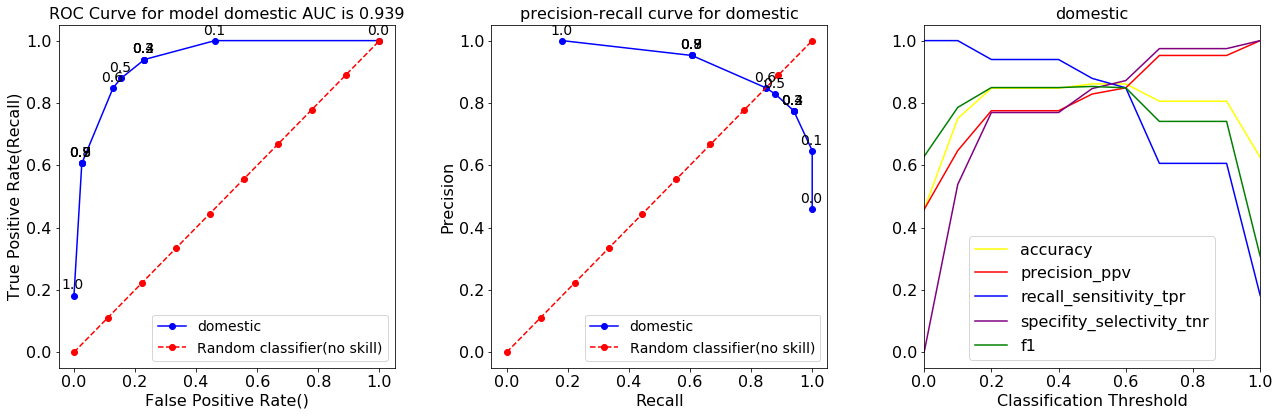

Max evaluation metric for model domestic
* Accuracy:  0.8611111111111112 at threshold  0.5
* Precision:  1.0 at threshold  1.0
* Recall:  1.0 at threshold  0.0
* F1:  0.8529411764705883 at threshold  0.5
* ROC-AUC 0.939
* Log Loss 0.29554178140638615



Metrics for green per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,green,0.0,159,154,0,0,0.507987,0.507987,1,0.673729,0.837724,0.56343,0,1,1
1,green,0.1,156,32,122,3,0.888179,0.829787,0.981132,0.899135,0.946602,0.856202,0.792208,0.981132,0.207792
2,green,0.2,153,18,136,6,0.923323,0.894737,0.962264,0.927273,0.947955,0.907473,0.883117,0.962264,0.116883
3,green,0.3,150,10,144,9,0.939297,0.9375,0.943396,0.940439,0.942211,0.938673,0.935065,0.943396,0.0649351
4,green,0.4,147,4,150,12,0.948882,0.97351,0.924528,0.948387,0.933926,0.963303,0.974026,0.924528,0.025974
5,green,0.5,147,4,150,12,0.948882,0.97351,0.924528,0.948387,0.933926,0.963303,0.974026,0.924528,0.025974
6,green,0.6,147,4,150,12,0.948882,0.97351,0.924528,0.948387,0.933926,0.963303,0.974026,0.924528,0.025974
7,green,0.7,147,4,150,12,0.948882,0.97351,0.924528,0.948387,0.933926,0.963303,0.974026,0.924528,0.025974
8,green,0.8,147,4,150,12,0.948882,0.97351,0.924528,0.948387,0.933926,0.963303,0.974026,0.924528,0.025974
9,green,0.9,134,1,153,25,0.916933,0.992593,0.842767,0.911565,0.869001,0.958512,0.993506,0.842767,0.00649351


<Figure size 432x288 with 0 Axes>

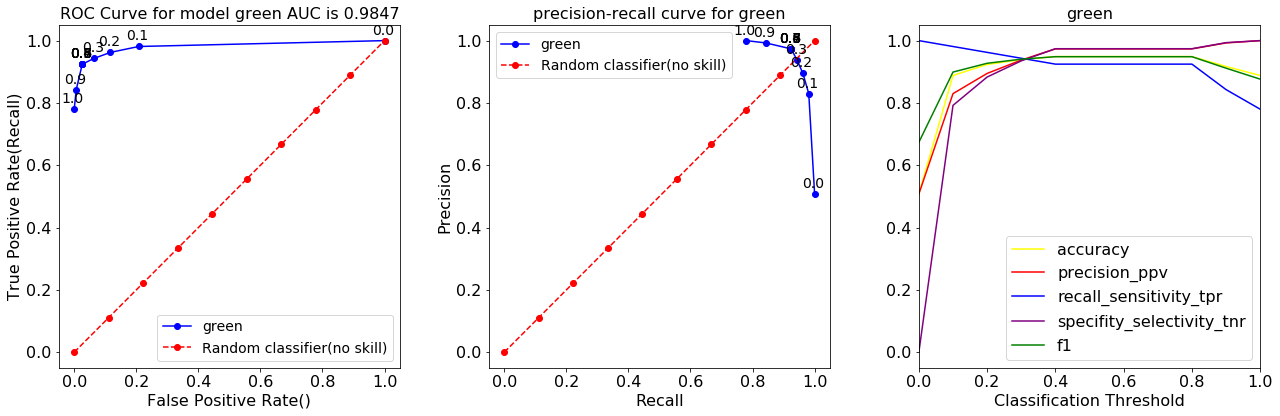

Max evaluation metric for model green
* Accuracy:  0.9488817891373802 at threshold  0.4
* Precision:  1.0 at threshold  1.0
* Recall:  1.0 at threshold  0.0
* F1:  0.9483870967741936 at threshold  0.4
* ROC-AUC 0.9847
* Log Loss 0.14057278854346184



Metrics for industrial per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,industrial,0.0,125,134,0,0,0.482625,0.482625,1,0.651042,0.823452,0.538329,0,1,1
1,industrial,0.1,121,54,80,4,0.776062,0.691429,0.968,0.806667,0.896296,0.733333,0.597015,0.968,0.402985
2,industrial,0.2,117,37,97,8,0.826255,0.75974,0.936,0.83871,0.894495,0.789474,0.723881,0.936,0.276119
3,industrial,0.3,117,37,97,8,0.826255,0.75974,0.936,0.83871,0.894495,0.789474,0.723881,0.936,0.276119
4,industrial,0.4,116,35,99,9,0.830116,0.768212,0.928,0.84058,0.890937,0.79561,0.738806,0.928,0.261194
5,industrial,0.5,107,24,110,18,0.837838,0.816794,0.856,0.835938,0.847861,0.824345,0.820896,0.856,0.179104
6,industrial,0.6,97,14,120,28,0.837838,0.873874,0.776,0.822034,0.793781,0.852373,0.895522,0.776,0.104478
7,industrial,0.7,93,12,122,32,0.830116,0.885714,0.744,0.808696,0.768595,0.853211,0.910448,0.744,0.0895522
8,industrial,0.8,88,10,124,37,0.818533,0.897959,0.704,0.789238,0.735786,0.851064,0.925373,0.704,0.0746269
9,industrial,0.9,36,1,133,89,0.65251,0.972973,0.288,0.444444,0.335196,0.659341,0.992537,0.288,0.00746269


<Figure size 432x288 with 0 Axes>

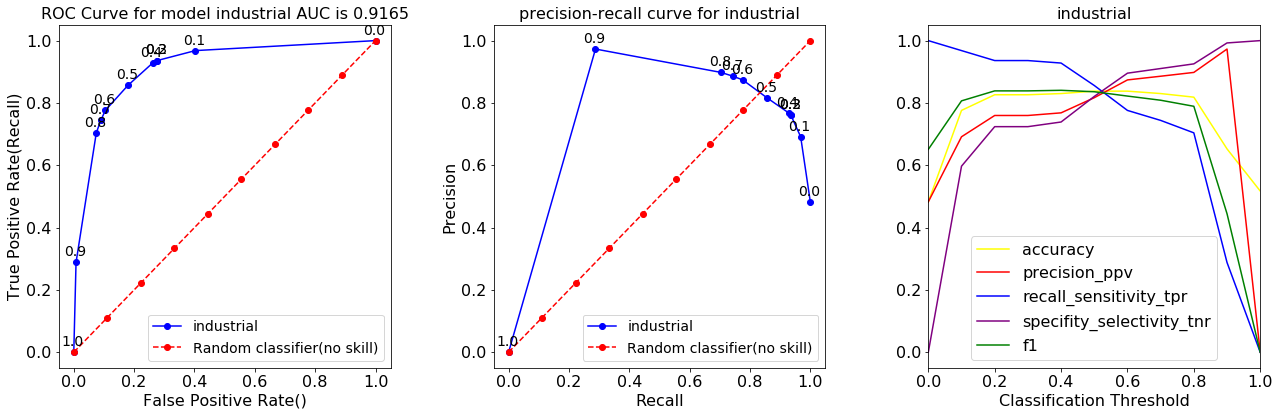

Max evaluation metric for model industrial
* Accuracy:  0.8378378378378378 at threshold  0.5
* Precision:  0.972972972972973 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.8405797101449276 at threshold  0.4
* ROC-AUC 0.9165
* Log Loss 0.35933433889374206



Metrics for inspired per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,inspired,0.0,29,36,0,0,0.446154,0.446154,1,0.617021,0.801105,0.50173,0,1,1
1,inspired,0.1,29,24,12,0,0.630769,0.54717,1,0.707317,0.857988,0.60166,0.333333,1,0.666667
2,inspired,0.2,29,24,12,0,0.630769,0.54717,1,0.707317,0.857988,0.60166,0.333333,1,0.666667
3,inspired,0.3,26,14,22,3,0.738462,0.65,0.896552,0.753623,0.833333,0.687831,0.611111,0.896552,0.388889
4,inspired,0.4,22,6,30,7,0.8,0.785714,0.758621,0.77193,0.763889,0.780142,0.833333,0.758621,0.166667
5,inspired,0.5,22,6,30,7,0.8,0.785714,0.758621,0.77193,0.763889,0.780142,0.833333,0.758621,0.166667
6,inspired,0.6,16,1,35,13,0.784615,0.941176,0.551724,0.695652,0.601504,0.824742,0.972222,0.551724,0.0277778
7,inspired,0.7,16,1,35,13,0.784615,0.941176,0.551724,0.695652,0.601504,0.824742,0.972222,0.551724,0.0277778
8,inspired,0.8,16,1,35,13,0.784615,0.941176,0.551724,0.695652,0.601504,0.824742,0.972222,0.551724,0.0277778
9,inspired,0.9,11,0,36,18,0.723077,1,0.37931,0.55,0.433071,0.753425,1,0.37931,0


<Figure size 432x288 with 0 Axes>

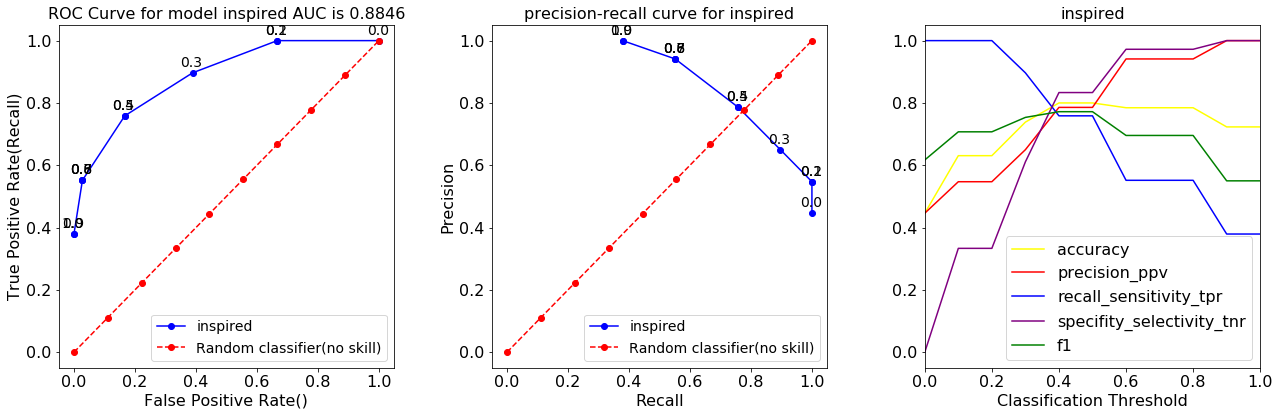

Max evaluation metric for model inspired
* Accuracy:  0.8 at threshold  0.4
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.7719298245614034 at threshold  0.4
* ROC-AUC 0.8846
* Log Loss 0.38374300072360207



Metrics for market per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,market,0.0,54,56,0,0,0.490909,0.490909,1,0.658537,0.828221,0.546559,0,1,1
1,market,0.1,54,41,15,0,0.627273,0.568421,1,0.724832,0.868167,0.62212,0.267857,1,0.732143
2,market,0.2,49,11,45,5,0.854545,0.816667,0.907407,0.859649,0.887681,0.833333,0.803571,0.907407,0.196429
3,market,0.3,49,11,45,5,0.854545,0.816667,0.907407,0.859649,0.887681,0.833333,0.803571,0.907407,0.196429
4,market,0.4,49,11,45,5,0.854545,0.816667,0.907407,0.859649,0.887681,0.833333,0.803571,0.907407,0.196429
5,market,0.5,49,11,45,5,0.854545,0.816667,0.907407,0.859649,0.887681,0.833333,0.803571,0.907407,0.196429
6,market,0.6,48,10,46,6,0.854545,0.827586,0.888889,0.857143,0.875912,0.839161,0.821429,0.888889,0.178571
7,market,0.7,34,1,55,20,0.809091,0.971429,0.62963,0.764045,0.677291,0.876289,0.982143,0.62963,0.0178571
8,market,0.8,34,1,55,20,0.809091,0.971429,0.62963,0.764045,0.677291,0.876289,0.982143,0.62963,0.0178571
9,market,0.9,28,0,56,26,0.763636,1,0.518519,0.682927,0.57377,0.843373,1,0.518519,0


<Figure size 432x288 with 0 Axes>

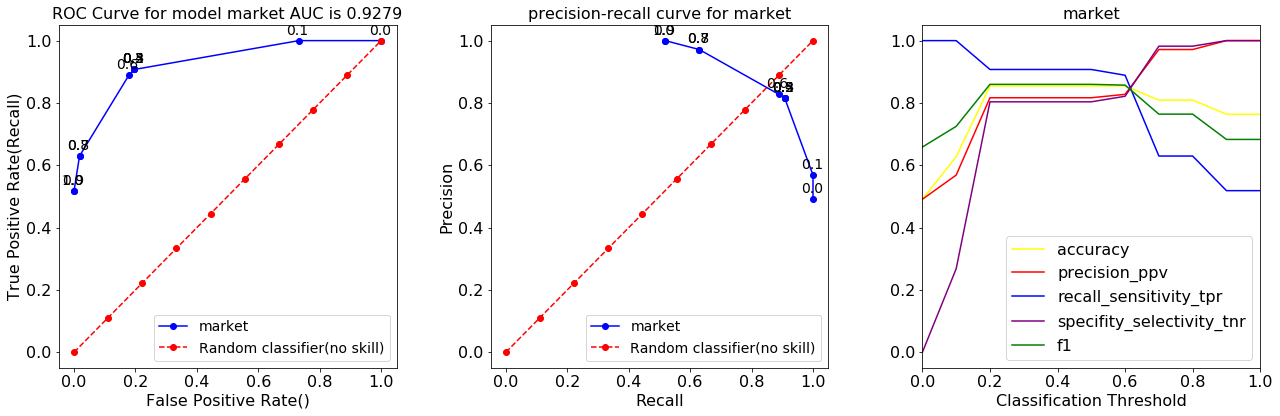

Max evaluation metric for model market
* Accuracy:  0.8545454545454545 at threshold  0.2
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.8596491228070176 at threshold  0.2
* ROC-AUC 0.9279
* Log Loss 0.30899572092264377



Metrics for project per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,project,0.0,70,56,0,0,0.555556,0.555556,1,0.714286,0.862069,0.609756,0,1,1
1,project,0.1,69,32,24,1,0.738095,0.683168,0.985714,0.807018,0.905512,0.727848,0.428571,0.985714,0.571429
2,project,0.2,67,18,38,3,0.833333,0.788235,0.957143,0.864516,0.917808,0.817073,0.678571,0.957143,0.321429
3,project,0.3,67,18,38,3,0.833333,0.788235,0.957143,0.864516,0.917808,0.817073,0.678571,0.957143,0.321429
4,project,0.4,67,18,38,3,0.833333,0.788235,0.957143,0.864516,0.917808,0.817073,0.678571,0.957143,0.321429
5,project,0.5,67,18,38,3,0.833333,0.788235,0.957143,0.864516,0.917808,0.817073,0.678571,0.957143,0.321429
6,project,0.6,65,16,40,5,0.833333,0.802469,0.928571,0.860927,0.900277,0.824873,0.714286,0.928571,0.285714
7,project,0.7,59,13,43,11,0.809524,0.819444,0.842857,0.830986,0.838068,0.824022,0.767857,0.842857,0.232143
8,project,0.8,45,9,47,25,0.730159,0.833333,0.642857,0.725806,0.673653,0.786713,0.839286,0.642857,0.160714
9,project,0.9,4,0,56,66,0.47619,1,0.0571429,0.108108,0.0704225,0.232558,1,0.0571429,0


<Figure size 432x288 with 0 Axes>

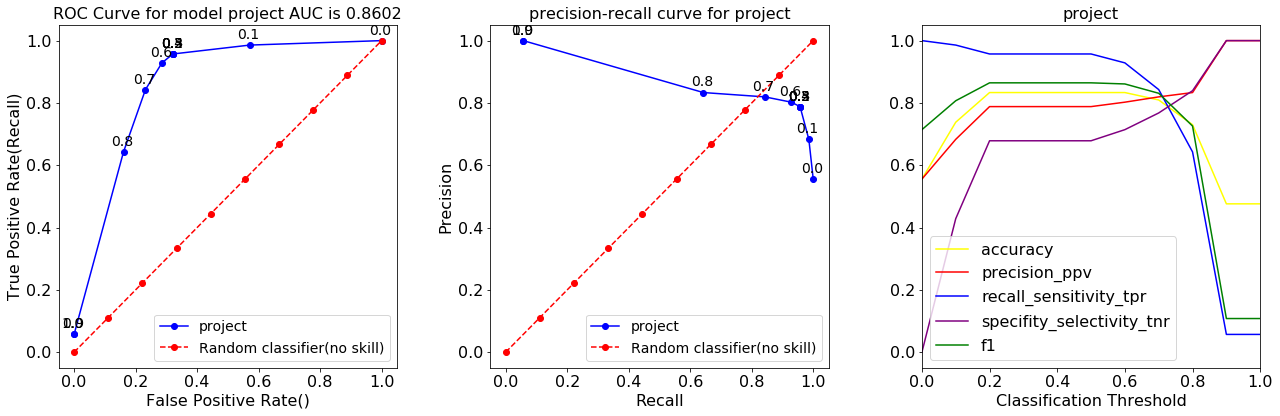

Max evaluation metric for model project
* Accuracy:  0.8333333333333334 at threshold  0.2
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.864516129032258 at threshold  0.2
* ROC-AUC 0.8602
* Log Loss 0.40866518508691974



Metrics for renown per Classification Threshold


,model,threshold,tp,fp,tn,fn,accuracy,precision_ppv,recall_sensitivity_tpr,f1,f2,f0_5,specifity_selectivity_tnr,tpr,fpr
0,renown,0.0,29,31,0,0,0.483333,0.483333,1,0.651685,0.823864,0.539033,0,1,1
1,renown,0.1,29,25,6,0,0.583333,0.537037,1,0.698795,0.852941,0.591837,0.193548,1,0.806452
2,renown,0.2,28,19,12,1,0.666667,0.595745,0.965517,0.736842,0.858896,0.645161,0.387097,0.965517,0.612903
3,renown,0.3,24,6,25,5,0.816667,0.8,0.827586,0.813559,0.821918,0.805369,0.806452,0.827586,0.193548
4,renown,0.4,24,6,25,5,0.816667,0.8,0.827586,0.813559,0.821918,0.805369,0.806452,0.827586,0.193548
5,renown,0.5,22,3,28,7,0.833333,0.88,0.758621,0.814815,0.780142,0.852713,0.903226,0.758621,0.0967742
6,renown,0.6,22,3,28,7,0.833333,0.88,0.758621,0.814815,0.780142,0.852713,0.903226,0.758621,0.0967742
7,renown,0.7,18,1,30,11,0.8,0.947368,0.62069,0.75,0.666667,0.857143,0.967742,0.62069,0.0322581
8,renown,0.8,18,1,30,11,0.8,0.947368,0.62069,0.75,0.666667,0.857143,0.967742,0.62069,0.0322581
9,renown,0.9,12,0,31,17,0.716667,1,0.413793,0.585366,0.46875,0.779221,1,0.413793,0


<Figure size 432x288 with 0 Axes>

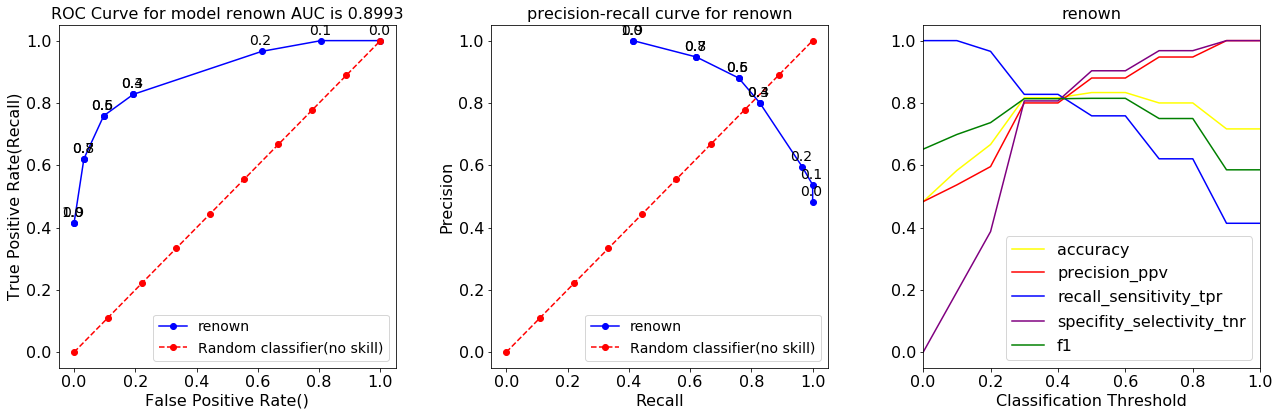

Max evaluation metric for model renown
* Accuracy:  0.8333333333333334 at threshold  0.5
* Precision:  1.0 at threshold  0.9
* Recall:  1.0 at threshold  0.0
* F1:  0.8148148148148148 at threshold  0.5
* ROC-AUC 0.8993
* Log Loss 0.36959679089949343


<Figure size 432x288 with 0 Axes>

In [361]:
#Generate a list of 100 possible tresholds between 0 and .96, 
# AF why .96?
#thresholds = np.linspace(0,0.96,100)
#thresholds = np.linspace(0,1,10)
#AF: We could evaluate thresholds from 0.0 to 1.0 in increments of 0.1?
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
tn_list = []
fp_list = [] 
fn_list = []
tp_list = []

dict_opt_f1_threshold = {}
dict_opt_precision_threshold = {}
dict_opt_recall_threshold = {}
dict_opt_accuracy_threshold = {}
dict_roc_auc = {}
dict_log_loss = {}

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16



metrics_for_all = pd.DataFrame()

# AF: at each step calculating the precision, recall, F1, and location on the ROC curve. 
#For each convention
for k in _DLModels.keys():
    tn_list = []
    fp_list = [] 
    fn_list = []
    tp_list = []

    #get the model, the validation data input(my_data_x) and the predicted label(y_predict) to compare to the actual label(y_actual).
    my_model = _DLModels[k]
    my_data_x = _DLData_val_x_txt_seq[k]
    my_ir = _DLModelsIsotonicRegression[k]
    
    y_actual = [int(x[0]<x[1]) for x in _DLData_val_y[k]]
    y_predict = my_model.predict(my_data_x)
    
    pos_predict_prob = get_positive_preds_probabilities(y_predict)
    y_predict_isotonic = my_ir.predict(pos_predict_prob)

    #Use the calibrated predictions probabilities.
    pos_predict_prob = y_predict_isotonic 


    dict_roc_auc[k] = roc_auc_score(y_actual ,pos_predict_prob).round(4)
    dict_log_loss[k] = log_loss(y_actual , pos_predict_prob, eps = 1e-7 )
    
    
    for t in thresholds:
        y_pred = get_positive_preds_with_threshold(pos_predict_prob,t)
        confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)
        tn, fp, fn, tp = confusion_matrix.ravel()
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
    print ("")
    display (HTML("<font color = green><h3><left>*** " + k + "***</left></h3></font>"))
    results_for_current_convention = pd.DataFrame({'threshold': thresholds,
                        'tp': tp_list,
                        'fp': fp_list,
                        'tn': tn_list,
                        'fn': fn_list
                       })
   
    metrics_df =  calculate_metrics(results_for_current_convention, len(y_actual), k);
    print("Metrics for " +k + " per Classification Threshold")
    display(metrics_df)
    metrics_for_all = pd.concat([metrics_for_all,metrics_df], sort = False)
    
    plt.figure(figsize=(18,6))
    plt.subplot(1, 3, 1)
    plt.style.use('seaborn-dark-palette')

    plt.rc('font', size =MEDIUM_SIZE )                  # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)   # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)   # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    my_thresholds = [str(t) for t in metrics_df['threshold']]
    plt.plot(metrics_df['fpr'], metrics_df['tpr'], 'bo-', label = k);
    plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
    for x, y, s in zip(metrics_df['fpr'], metrics_df['tpr'], my_thresholds):
        plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
    plt.legend(prop={'size':14})
    plt.ylabel('True Positive Rate(Recall)'); plt.xlabel('False Positive Rate()');
    plt.title('ROC Curve for model '+k + " AUC is " + str(dict_roc_auc[k]))
    #plt.show()
    #plt.clf()
    

    plt.subplot(1, 3, 2)
    plt.style.use('seaborn-dark-palette')
    plt.plot(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], 'bo-', label = k);
    plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'Random classifier(no skill)');
    for x, y, s in zip(metrics_df['recall_sensitivity_tpr'], metrics_df['precision_ppv'], my_thresholds):
        plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});
    plt.legend(prop={'size':14})
    plt.ylabel('Precision'); plt.xlabel('Recall');
    plt.title('precision-recall curve for '+k )
    #plt.show()
    #plt.clf()
    
    plt.subplot(1, 3, 3)
    ax = plt.gca()
    plt.title(k)
    metrics_df.plot(kind='line',x='threshold',y='accuracy', color='yellow',ax=ax)
    metrics_df.plot(kind='line',x='threshold',y='precision_ppv', color='red', ax=ax)
    metrics_df.plot(kind='line',x='threshold',y='recall_sensitivity_tpr', color='blue',ax=ax)
    metrics_df.plot(kind='line',x='threshold',y='specifity_selectivity_tnr', color='purple',ax=ax)
    metrics_df.plot(kind='line',x='threshold',y='f1', color='green', ax=ax)
    plt.xlabel('Classification Threshold')
    plt.tight_layout()
    plt.show()
    plt.clf()
    print ("Max evaluation metric for model", k)

    best = metrics_df[['recall_sensitivity_tpr','precision_ppv', 'f1', 'accuracy']].max()
    try:
        best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'].iloc[0]
    except:
        best_precision_threshold = metrics_df[['threshold']][metrics_df.precision_ppv == best[1]]['threshold'] 
    
    try:
        best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold'].iloc[0]     
    except:
        best_recall_threshold = metrics_df[['threshold']][metrics_df.recall_sensitivity_tpr == best[0]]['threshold']
    
    try:
        best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold'].iloc[0] 
    except:
        best_F1_threshold = metrics_df[['threshold']][metrics_df.f1 == best[2]]['threshold']
        
    try:
        best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold'].iloc[0] 
    except:
        best_accuracy_threshold = metrics_df[['threshold']][metrics_df.accuracy == best[3]]['threshold']
   
    dict_opt_f1_threshold[k] = best_F1_threshold
    dict_opt_precision_threshold[k] = best_precision_threshold
    dict_opt_recall_threshold[k]  =  best_recall_threshold
    dict_opt_accuracy_threshold[k]  =  best_accuracy_threshold
    print ("* Accuracy: ", best [3], "at threshold ", best_accuracy_threshold)
    print ("* Precision: ", best [1], "at threshold ", best_precision_threshold)
    print ("* Recall: ", best [0], "at threshold ", best_recall_threshold)
    print ("* F1: ", best [2], "at threshold ", best_F1_threshold)
    print ("* ROC-AUC", dict_roc_auc[k])
    print ("* Log Loss",dict_log_loss[k])

gc.collect()


metrics_for_all = metrics_for_all.reset_index().drop("index",  axis=1)


# Further Metrics analysis for selection of Threshold

In [362]:
accuracyHTML = HTML ('<b>Accuracy = (TP + TN)/(TP + FP + TN + FN)</b> <br/>The probability that the classification result is correct, ie probability of correctly labelling sentences as class 1 or Class 0, given all the sentences! Accuracy is simply the ratio of the correctly labeled sentences out of all sentences. Good measure with balanced data and when false positive and false negative have a similar “cost”')
precisionHTML = HTML ('<b>Precision or Positive prediction value =  TP / (TP + FP)</b> <br/>The probability that a sentences we have labeled as Class 1(belonging to the convention) is actually Class 1. eg in green model, the probability that a sentenced classified as positive(1) for green, is actually green.Our focus then in terms of performance might be on identifying the actually positive cases, i.e to maximise the "precision". Although a model with unbalanced data could also "cheat" and maximise this by always returning “negative”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is a priority then we should choose a model with higher Recall/Sensitivity.')
recallHTML = HTML ('<b>Recall or Sensitivity or TPR =  TP / (TP + FN)</b><br/>Given the sentence is part of the convention, how likely is it that the classification will be positive? Our focus then in terms of performance could maybe be in terms of higher importance on identifying the positive cases, i.e to maximise the "recall" or "sensitivity". Although a model could also "cheat" and maximise this by always returning “positive”. This metric is important if the most important function of the model will be to identify positives (Class 1). If this is most important to us then we should choose a model with higher Recall/Sensitivity.')
specificityHTML = HTML('<b> Specificity or TNR = TN / (TN + FP)</b><br/>How good a classifier is at avoiding false alarms. Given the sentence does not belong to the convention, how likely is it that the classification will be negative(class 0). If correctly identifying negatives is most important, then we should choose specificity as the measurement metric. A classifier can "cheat" and maximise this by always returning “negative” Class 0.')
F_scoreHTML = HTML ('<b>F1 =  2 * ( (Precision * Recall) / (Precision + Recall)) or Fi = (1 + i^2) * ( (precision * recall) / (i^2 * (Precision + Recall)</b><br/>If we want to find an optimal blend of precision and recall we can combine the two metrics using what is called the F-score, this is the harmonic mean of precision and recall (harmonic mean is used as it punishes extreme values). Note: there are other F measures: <br/>* F2 which weights recall higher than precision<br/>* F0.5 which puts more emphasis on precision than recall.')
metricsGenHTML = HTML ("If correctly identifying positives is important for us, then we should choose a model with higher Recall/Sensitivity. <br/>If correctly identifying negatives is more important, then we should choose higher precision/specificity as the measurement metric.")

my_style = {'description_width': 'initial'}
my_layout = {'width': '600px'}
my_layout_short = {'width': '300px'}
my_layout_shortest = {'width': '250px'}

classifier_thresholds = {}

threshold_best_all = metrics_for_all.head(1).copy()
threshold_t_calab_all = metrics_for_all.head(1).copy()
global_pos_validation_df = pd.DataFrame()
convention_list = []


metrics_list = ['accuracy', 'precision_ppv','recall_sensitivity_tpr','f1','f2','f0_5','specifity_selectivity_tnr']


metric_drop_down = widgets.Dropdown(
            options= metrics_list,
            value= metrics_list[0],
            description='Review Metric  :',
            disabled=False,
            style = my_style,
            layout = my_layout
        )

use_metric_drop_down = widgets.Dropdown(
            options = ["--select--","max value", "T calab"],
            value= "--select--",
            description='Select tresholds to generate results :',
            disabled=False,
            style = my_style,
            layout = my_layout
        )


#Plot the precision v's the classification treshold for all models. This is plotting at which threshold each classifier 
#meets a minimum precision score. 
confidence_goal_slider = widgets.FloatSlider(
            min=0, 
            max=1,
            value = .8,
            step = 0.05,
            description='Confidence level:',
            style = my_style,
            layout = my_layout
            )

confidence_goal_slider.style.handle_color = '#5c85d6'

selectSettingForCoOccurHTML = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

headingHTML = widgets.HTML(
            "<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")



output_metrics_info = widgets.Output()



    

def results_output_function(use_metric_drop_down_value ):
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global global_pos_validation_df
    thresholds = {}
    if use_metric_drop_down_value == "--select--":
        #with results_output:
        clear_output(wait=True)
        print ("Select from dropdown to generate analysis")
        return
    for k in _DLModels.keys():
        try:
            if use_metric_drop_down_value == "max value":
                threshold = threshold_best_all [threshold_best_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold
            if use_metric_drop_down_value == "T calab":
                threshold = threshold_t_calab_all [threshold_t_calab_all.model == k]['threshold'].iloc[0]
                thresholds[k] = threshold
        except:
            print ("No entry for: ", k)

    print (thresholds)
    all_validation_df = get_validation_data(thresholds, _DLModels, _DLData_val_x_txt_seq, _DLData_val_x_txt, _DLData_val_y) 
    display(all_validation_df.head(2))
    
    def my_inner_funct(all_validation_df):
        co_occur_list = []
        rename = []
        for x in all_validation_df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))
        y_actual_list = rename
        co_occur_y_predict = all_validation_df[co_occur_list].copy()
        co_occur_y_actual = all_validation_df[y_actual_list].copy()

    
        for old, x in zip(co_occur_list, range(len(co_occur_list))): 
            co_occur_y_predict = co_occur_y_predict.rename(columns={old: rename[x]})
        
 
        text = "Predicted Co-occurance Matrix "
        display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
        model_helpers.co_occurance_matrix (co_occur_y_predict)
        text = "Predicted Sentence/Label cardinality"
        display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
        model_helpers.label_cardinality_bar(co_occur_y_predict)   
    
        text = "Actual Sentence/Label cardinality"
        display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
        model_helpers.label_cardinality_bar(co_occur_y_actual)
        
    my_inner_funct(all_validation_df)
    only_positive_df = all_validation_df.loc[all_validation_df['pos_sample'] > 0]
    text = "Lets repeat this looking only at validation data that had Class = 1(because class=0 are class=1 for something)"  
    display (HTML("<font color = orange><h3><left>" + text + "</left></h3></font>"))
    print ("number of validation samples:",only_positive_df.shape[0] )
    my_inner_funct(only_positive_df)
    global_pos_validation_df = only_positive_df
    
    
def output_function(metric_drop_down_value, confidence_goal_slider_value ):
    global thresholds
    global metrics_for_all
    global threshold_best_all
    global threshold_t_calab_all
    global _DLModels
    global classifier_thresholds
    global output_metrics_info
    classifier_thresholds = {}
    threshold_best_all = metrics_for_all.head(1).copy()
    threshold_t_calab_all = metrics_for_all.head(1).copy()
    
    with output_metrics_info:
        clear_output(wait=True)
        if metric_drop_down_value == 'accuracy':
            display (accuracyHTML)
        if metric_drop_down_value == 'precision_ppv':
            display (precisionHTML)
        if metric_drop_down_value == 'recall_sensitivity_tpr':   
            display (recallHTML)
        if metric_drop_down_value == 'specifity_selectivity_tnr':
            display (specificityHTML)
        if metric_drop_down_value == 'f1':
            display (F_scoreHTML)
        if metric_drop_down_value == 'f2':
            display (F_scoreHTML)
        if metric_drop_down_value == 'f0_5':
            display (F_scoreHTML)
        display (metricsGenHTML)
    
    plt.figure(figsize=(10,7))

    performance_goal = confidence_goal_slider_value
    metric = metric_drop_down_value
    auc = []
    auc_t_calab = []
    for k in _DLModels.keys():
        x = thresholds
        y =  metrics_for_all [metrics_for_all.model == k][metric].to_numpy()
        plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label=k.capitalize()+" model")
        t_index=None
        try:
            t_index = np.argwhere(y > performance_goal)[0]
        except:
            pass    
        if t_index is not None:
            classifier_thresholds[k] = x[t_index[0]]
            thresh = x[t_index[0]]
            auc_t_calab.append(dict_roc_auc[k])
            threshold_t_calab =  metrics_for_all [(metrics_for_all.model == k) & (metrics_for_all['threshold'] == thresh )].iloc[0].to_frame().transpose()
            threshold_t_calab_all = pd.concat([threshold_t_calab_all,threshold_t_calab], sort = False)
        
        auc.append(dict_roc_auc[k])
        best = metrics_for_all [metrics_for_all.model == k][metric].max()
        threshold_best =  metrics_for_all [(metrics_for_all.model == k) & (metrics_for_all[metric] == best )].iloc[0].to_frame().transpose()
        threshold_best_all = pd.concat([threshold_best_all,threshold_best], sort = False)
        
        
        
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis =1).drop(0)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis =1).drop(0)
    # Declare a list that is to be converted into a column 
    
    threshold_best_all['auc'] = auc
    threshold_t_calab_all['auc'] = auc_t_calab
    
    
    micro = threshold_best_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp = micro[0]
    fp = micro[1]
    tn = micro[2]
    fn = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp, fp, tn, fn]) 
    threshold_best_all = pd.concat([threshold_best_all,micro_ave_df], sort = False)
    threshold_best_all = threshold_best_all.reset_index().drop('index', axis =1)
    
    micro = threshold_t_calab_all[['tp', 'fp', 'tn', 'fn']].sum(axis=0)
    tp_t = micro[0]
    fp_t = micro[1]
    tn_t = micro[2]
    fn_t = micro[3]
    micro_ave_df = calculate_full_set_micro_average([tp_t, fp_t, tn_t, fn_t]) 
    threshold_t_calab_all = pd.concat([threshold_t_calab_all,micro_ave_df], sort = False)
    threshold_t_calab_all = threshold_t_calab_all.reset_index().drop('index', axis =1)

    #plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)
    plt.xlabel("Confidence threshold ($T_{calibration}$)", fontsize=14)
    plt.ylabel(metric + " score", fontsize=14)
    plt.hlines(y=performance_goal, xmin=0, xmax=1.00001, color='black', linestyle=":", lw=4, label="$T_{precision}$")
    plt.legend(fontsize=15, bbox_to_anchor=(1.01, 1.01))
    plt.show()
    plt.clf()
    gc.collect()
    
    display (HTML("<font color = green><h3><left>Evaluation Metrics summary per model:</left></h3></font>"))
    text = "Using probability/Classification Threshold based on T calab for "  + metric
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_t_calab_all)
    display(HTML("To measure a multi-class classifier we have to average out the classes somehow. There are two different methods of doing this called micro-averaging and macro-averaging.<br/> * In micro-averaging all TPs, TNs, FPs and FNs for each class are summed up and then the average is taken.<br/>* Macro-averaging is just the average of the precision and recall of the system on different sets"))
    print ("")
    print ("")
    text = "Using Probability/Classification Threshold based on max "  + metric 
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display(threshold_best_all)
    use_metric_drop_down.value = "--select--"

    

main_output = widgets.interactive_output( output_function, {
                'metric_drop_down_value': metric_drop_down,
                'confidence_goal_slider_value': confidence_goal_slider,

                })

results_output = widgets.interactive_output( results_output_function, {
                'use_metric_drop_down_value':use_metric_drop_down
                })


display(headingHTML, 
        metric_drop_down,
        output_metrics_info,
        confidence_goal_slider, 
        main_output, 
        selectSettingForCoOccurHTML, 
        use_metric_drop_down, 
        results_output)



# https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
# AF:  whert is the equalized_precisions_threshold set?

HTML(value="<font color = '#8c8c8c'><h1><center>***  View Evaluation Metrics   ***</center></h1></font>")

Dropdown(description='Review Metric  :', layout=Layout(width='600px'), options=('accuracy', 'precision_ppv', '…

Output()

FloatSlider(value=0.8, description='Confidence level:', layout=Layout(width='600px'), max=1.0, step=0.05, styl…

Output()

HTML(value="<font color = '#8c8c8c'><h1><center>***  Generate co-occurance matrix   ***</center></h1></font>")

Dropdown(description='Select tresholds to generate results :', layout=Layout(width='600px'), options=('--selec…

Output()

# Note that at this point we have a validation DataFrame with:
- One row per unique sentence
- y_actual in column {model)
- The true/false y_predicted of each individual calibrated model in {model}_y_pred
- The probability confidence score of y_pred whether 0 or 1 in {model}_prob
- The probability confidence score of True(1) in {model}_prob_1
- The Set confidence of entire model set (in column 'set_conf'), calculated as the sum of the individual {model}_y_pred confidences. 
- The per sentence cardinality, across entire model set (in column 'lbl_cnt')

There are two types of confidence scores in BR: 
     * The confidence of an individual label prediction p(yl|x)
     * The confidence of the entire predicted set p(y|x). 

A natural requirement in many end-use applications is that the classifier provides a well-calibrated confidence (probability) to indicate the likelihood of the predicted set being correct; for example, an application may automate high-confidence predictions while manually verifying low-confidence predictions.

The individual label confidence scores has already been calibrated, with Isotonic regression.
(the established procedures are isotonic regression or Platt scaling). We should also be concerned with the set confidence calibration; as calibrating all individual label(individual model) confidence scores does not automatically calibrate the overall set prediction confidence score.

Here we will review how well calibrated the entire model set is.

In [365]:
thresholds_calab = {}
thresholds_max = {}
for k in _DLModels.keys():
        try:
                threshold_calab = threshold_t_calab_all [threshold_t_calab_all.model == k]['threshold'].iloc[0]
                thresholds_calab[k] = threshold_calab
                threshold_max = threshold_best_all [threshold_best_all.model == k]['threshold'].iloc[0]
                thresholds_max[k] = threshold_max
        except:
            print ("No entry for: ", k)
            
print ("Thresholds used in calibrated individual models to calculate y-predict")
display(thresholds_calab)
display(thresholds_max)
global_pos_validation_df = global_pos_validation_df.reset_index()
global_pos_validation_df = global_pos_validation_df.drop('index', axis = 1)

Thresholds used in calibrated individual models to calculate y-predict


{'civic': 0.3,
 'domestic': 0.2,
 'green': 0.1,
 'industrial': 0.2,
 'inspired': 0.4,
 'market': 0.2,
 'project': 0.2,
 'renown': 0.3}

{'civic': 0.4,
 'domestic': 0.7,
 'green': 0.4,
 'industrial': 0.7,
 'inspired': 0.6,
 'market': 0.7,
 'project': 0.6,
 'renown': 0.7}

# Review the calibration of the confidence of the entire Binary Relevance Set(The probability associated with the set of predicted labels should reflect its ground truth correctness likelihood)

https://ecmlpkdd2019.org/downloads/paper/391.pdf


There are three scoring methods we can use to evaluate the predicted probabilities on your classification predictive modeling problem.

    -The log loss (or cross entropy)score that heavily penalizes predicted probabilities far away from their expected value.
    
    -The Brier score(MSE) that is gentler than log loss but still penalizes proportional to the distance from the expected value.
    
    -The area under ROC curve that summarizes the likelihood of the model predicting a higher probability for true positive cases than true negative cases.
    
 
As discussed in the above paper we will use the Brier score(MSE)

Method: 
    - 1. Calculate the set confidence per sample/sentence as the product of the individual label confidences(this is in "set_conf" column
    - 2. group about every 10 predictions with similar set confidence scores into a bucket, and plot those buckets as dots 
    -3. treating the average confidence in the group as the x-coordinate
    -4. treating the average prediction accuracy (using MSE/Brier score) in the group as the y-coordinate
    -5. we will plot also based on lable cardinality (this could be extended further to consider probability of lable combination. 
    
    


In [370]:
#In the multilabel case with binary label indicators: , np.ones((2, 2)
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, hamming_loss

#Exact match, note [[]]
score = accuracy_score(np.array([[1, 0, 0, 0, 0, 0, 0, 0]]), np.array([[1, 1, 0, 0, 0, 0, 0, 0]]))
print (score)

#Accuracy, average over all labels
score = accuracy_score(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([1, 1, 1, 0, 1, 1, 0, 0]))
print (score)

#takes into account how wrong a prediction is in terms of probability scores.
score = brier_score_loss(np.array([1, 1, 1, 1, 0, 0, 0, 0]), np.array([.7, .7, .7, .3, .7, .7, .3, .3]))
print (1-score)


0.0
0.625
0.76


In [498]:
#we need to create a new dataframe with one v
global_pos_validation_df = global_pos_validation_df.drop(['MSE','MSE_accuracy','exact_match','accuracy','color','conf_bin','cardinality'],axis =1)
def generate_set_accuracy_scores (global_pos_validation_df, thresholds, num_conf_bins=100):
    y_actual_list = []
    y_predict_prob_list = []
    y_predict_list = []
    brier_score = []
    exact_match = []
    accuracy = []

    for conv in thresholds:
        y_actual_list.append(conv)
        y_predict_prob_list.append(conv+"_prob_1") #
        y_predict_list.append(conv+"_y_pred") 
    
    y_actual_df = global_pos_validation_df[y_actual_list]
    y_predict_prob_df = global_pos_validation_df[y_predict_prob_list]
    y_predict_df = global_pos_validation_df[y_predict_list]
    for row in range(y_actual_df.shape[0]):
        actual = []
        predict = []
        actual.append( np.array(y_actual_df.iloc[row]) )
        predict.append( np.array(y_predict_df.iloc[row]) )
        brier_score.append(brier_score_loss(y_actual_df.iloc[row] , y_predict_prob_df.iloc[row]))
        accuracy.append(accuracy_score( np.array(y_actual_df.iloc[row]), np.array(y_predict_df.iloc[row]) ))
        exact_match.append(accuracy_score( np.array(actual), np.array(predict)  ))
    
    global_pos_validation_df["MSE"] = brier_score
    global_pos_validation_df["MSE_accuracy"] = 1 - global_pos_validation_df["MSE"]
    global_pos_validation_df["exact_match"] = exact_match
    global_pos_validation_df["accuracy"] = accuracy
    #assigns a color to each lbl_cnt
    colors = ['orange', 'green',  'yellow','pink', 'purple', 'blue', 'brown', 'black', 'red']
    cardinality = []
    for x in range(global_pos_validation_df.shape[0]):
        cardinality.append (global_pos_validation_df.iloc[x].lbl_cnt)
    global_pos_validation_df['cardinality'] = cardinality


    color = []
    for x in range(global_pos_validation_df.shape[0]):
        y = global_pos_validation_df.iloc[x].cardinality
        color.append(colors[int(y)]) 
    global_pos_validation_df['color'] = color
    
    global_pos_validation_df['conf_bin'] = pd.qcut(global_pos_validation_df['set_conf'], q=num_conf_bins, duplicates='drop')
    return global_pos_validation_df
    

<Figure size 432x288 with 0 Axes>

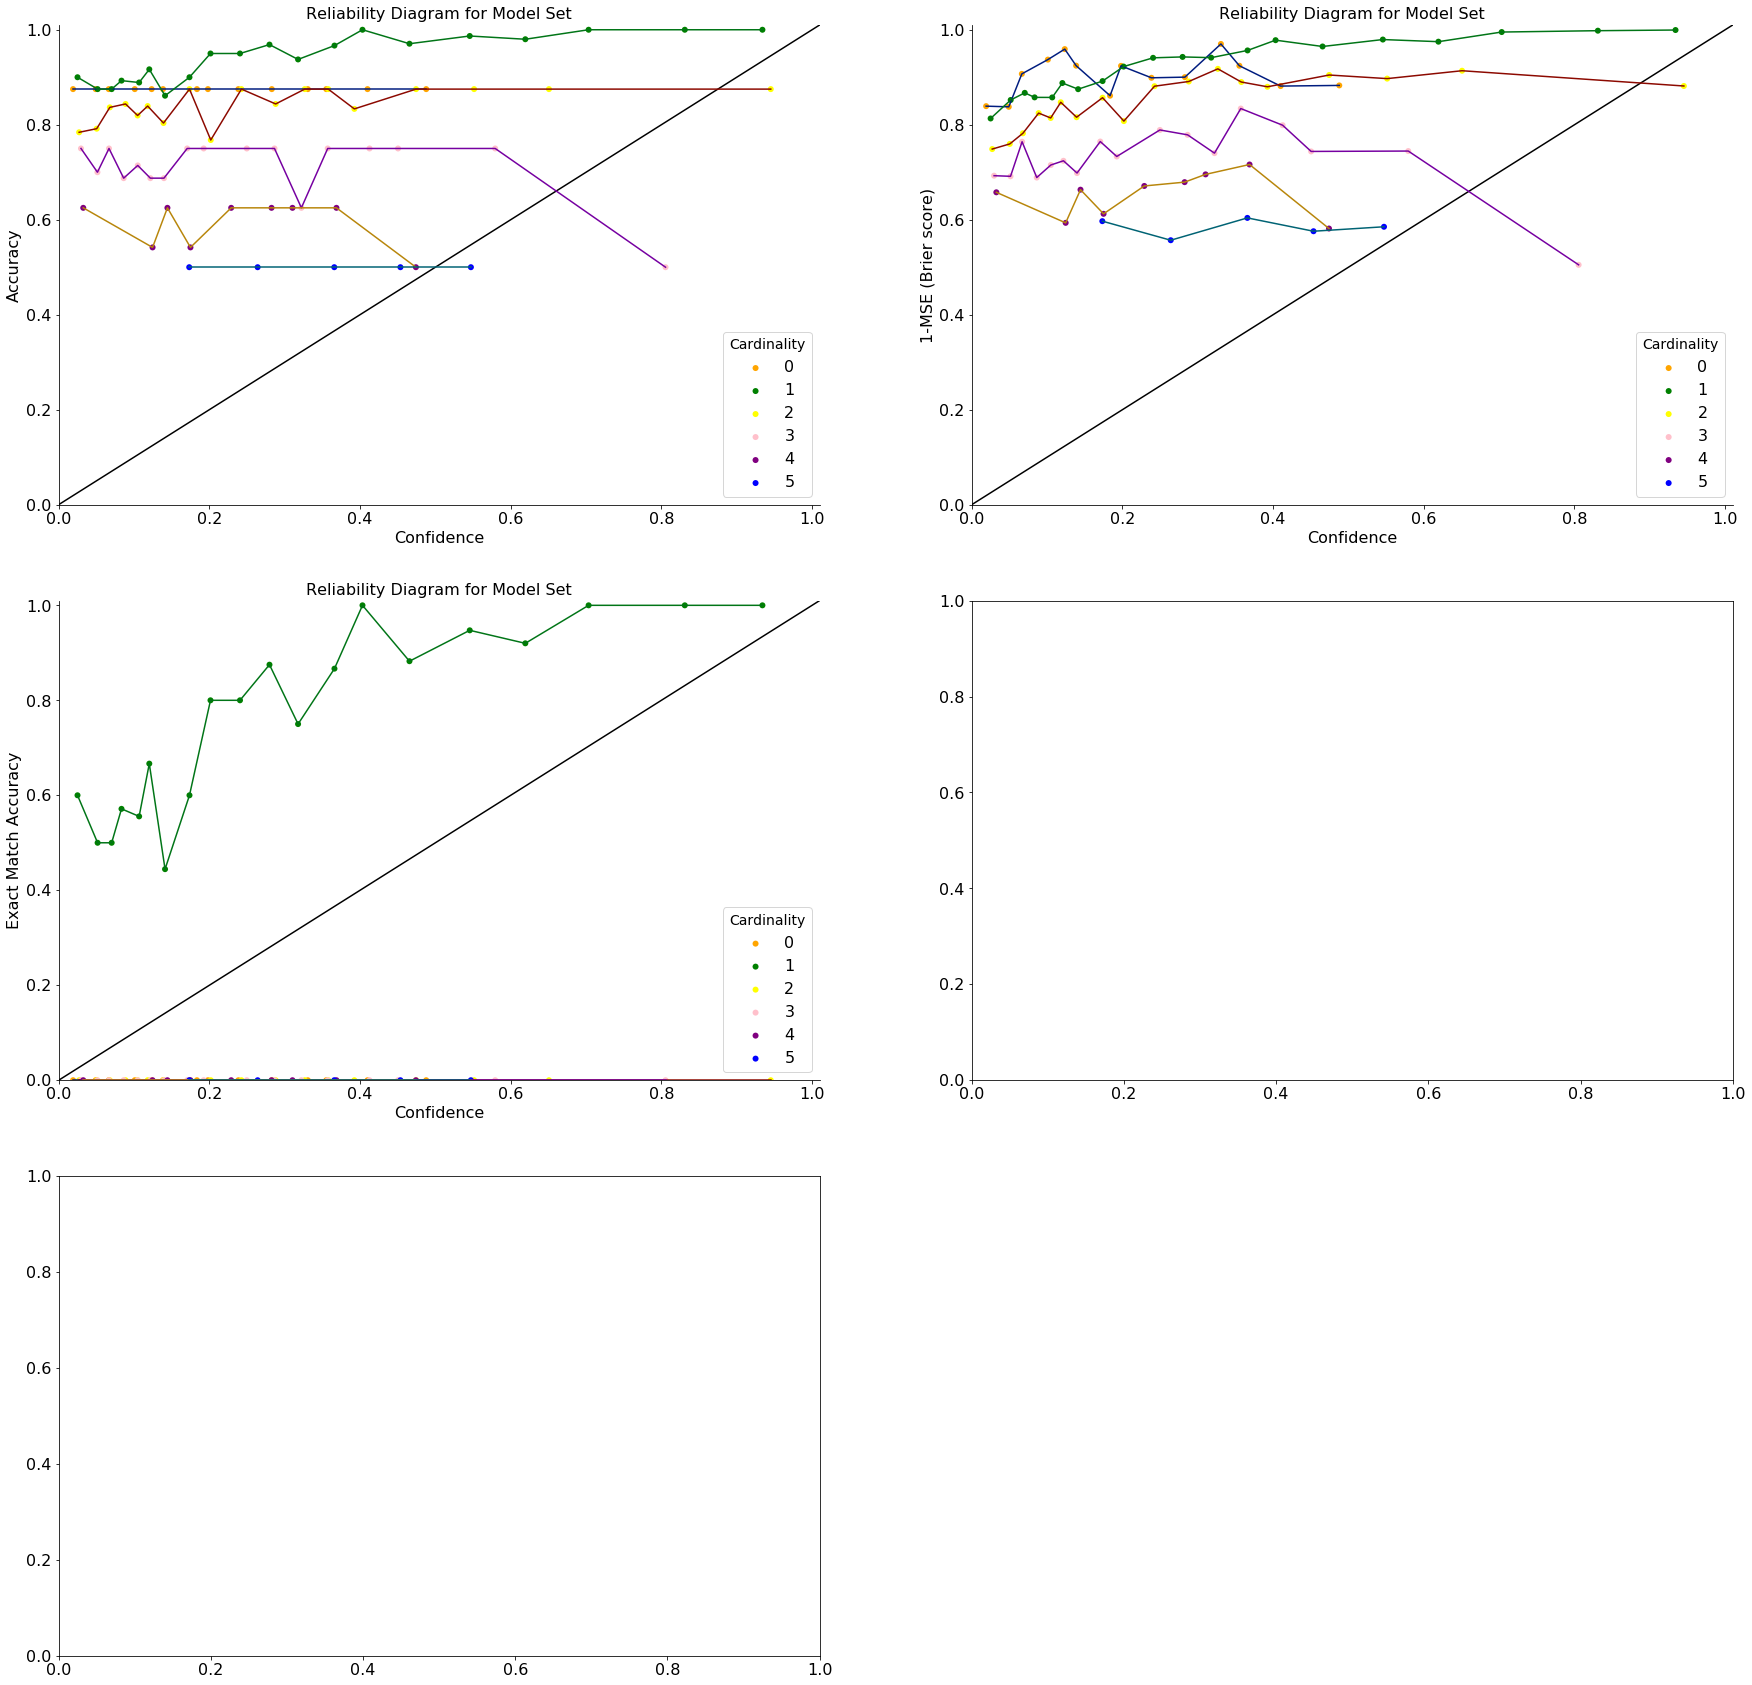

In [519]:
def plot_reliability(global_pos_validation_df):
    plt.clf()
    colors = {0:'orange', 1:'green',  2:'yellow',3:'pink', 4:'purple', 5:'blue', 6:'brown', 7:'black', 8:'red'}
    #colors = {'orange':0, 'green':1,  'yellow':2,'pink':3, 'purple':4, 'blue':5, 'brown':6, 'black':7, 'red':8}
    
    #group by confidence bin for the purpose of readability/standard format for reliability curve.
    binned_mean_df = global_pos_validation_df.groupby(['conf_bin', 'lbl_cnt']).mean()
    binned_mean_df = binned_mean_df.dropna().reset_index()
    color_list = []
    for x in range(binned_mean_df.shape[0]):
        y = binned_mean_df.iloc[x].cardinality
        color_list.append(colors[int(y)]) 
    binned_mean_df['color'] = color_list
    binned_mean_df = binned_mean_df[['set_conf', 'MSE', 'MSE_accuracy', 'exact_match', 'accuracy','cardinality', 'color', 'conf_bin']].dropna()
    ###########
    
    
    plt.figure(figsize=(30,30))
    ax1 = plt.subplot(3, 2, 1)
    ax2 = plt.subplot(3, 2, 2)
    ax3 = plt.subplot(3, 2, 3)
    ax4 = plt.subplot(3, 2, 4)
    ax5 = plt.subplot(3, 2, 5)

    def my_sub_funct (ax, df, metric, ylabel, plot_line = False):
        #force it to start at 0 to 1
        ax.set_ylim(ymin=0, ymax=1.01)
        ax.set_xlim(xmin=0, xmax=1.01)
        #removing top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #draw the "unskilled" line
        line = mlines.Line2D([0, 1], [0, 1], color='black')
        transform = ax.transAxes
        line.set_transform(transform)
        ax.add_line(line)
        # Add title and axis names
        ax.set_title('Reliability Diagram for Model Set')
        ax.set_xlabel('Confidence')
        ax.set_ylabel(ylabel)

        #global_pos_validation_df.plot.scatter(ax = ax, x = 'set_conf', y = 'accuracy', s=None, c=list(global_pos_validation_df['color']), label = label, figsize=(10,10))
        for i, dff in df.groupby("cardinality"):

            ax.scatter( dff['set_conf'], dff[metric], s=None, c=dff['color'], 
                        edgecolors='none', label="{}".format(int(i)))
            ax.legend(title = "Cardinality")
            if plot_line == True:
                ax.plot( dff['set_conf'], dff[metric])
        if plot_line == True:
            handles, labels = ax.get_legend_handles_labels()
            cut_by = len(handles)/2
            ax.legend(handles[int(cut_by):], labels[int(cut_by):], title = "Cardinality")
       #######################  
    
    
    my_sub_funct (ax1, binned_mean_df, "accuracy", "Accuracy", plot_line = True )
    my_sub_funct (ax2, binned_mean_df, "MSE_accuracy", "1-MSE (Brier score)", plot_line = True )
    my_sub_funct (ax3, binned_mean_df, "exact_match", "Exact Match Accuracy", plot_line = True )
    #my_sub_funct (ax4, global_pos_validation_df, "accuracy", "Accuracy", plot_line = False)
    #my_sub_funct (ax5, global_pos_validation_df, "exact_match", "Exact Match Accuracy", plot_line = False )
    
    plt.show()
    gc.collect()
    
global_pos_validation_df = generate_set_accuracy_scores (global_pos_validation_df, thresholds_calab, 20)
plot_reliability(global_pos_validation_df)

In [ ]:
#In the reliability diagram note that, predictions above the diagonal are under-confident and those below the diagonal are over-confident.
Both set cardinality and prior probability are features defined on the whole
label set, rather than individual labels. Such features capture constraints and
dependencies among labels, which were not originally considered by BR. Therefore these features 
supplement BR’s own prediction score and allow the calibrator to
make better overall judgments on the predicted set. the result will basically be a beter calibrated confidence score.


Each BR set prediction is transformed to a feature vector containing: 
- Original BR confidence score: 
- set cardinality, 
- set prior probability,
- set binary representation

and the binary correctness of the prediction is used as the regression target

In [607]:
print (thresholds_calab)
y_actual_list = []
for conv in thresholds_calab:
        y_actual_list.append(conv)
y_actual_list.append ('set_conf')
y_actual_list.append ('cardinality')
print (y_actual_list)


{'civic': 0.3, 'domestic': 0.2, 'green': 0.1, 'industrial': 0.2, 'inspired': 0.4, 'market': 0.2, 'project': 0.2, 'renown': 0.3}
['civic', 'domestic', 'green', 'industrial', 'inspired', 'market', 'project', 'renown', 'set_conf', 'cardinality']


In [597]:
from sklearn.utils import shuffle
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

X, y = shuffle(to_calibrate_x, to_calibrate_y_actual, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
print("1111")
clf.fit(X_train, y_train['exact_match'])
#mse = mean_squared_error(y_test, clf.predict(X_test))
#print("MSE: %.4f" % mse)
print (type(X_test))
print (type(clf.predict(X_test)))
X_test['calibrated_conf'] = list(clf.predict(X_test))

display (X_test.head())
display (y_test.head())
display (X_test.shape[0])

1111
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


/Users/aideenf/.pyenv/versions/3.6.0/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,civic,domestic,green,industrial,inspired,market,project,renown,set_conf,cardinality,calibrated_conf
261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.234249,0.0,0.166218
147,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.136364,1.0,0.434849
222,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374022,4.0,0.019507
420,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.742063,1.0,0.995595
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.015702,0.0,-0.009158


,exact_match
261,0.0
147,0.0
222,0.0
420,1.0
190,0.0


55

,civic,domestic,green,industrial,inspired,market,project,renown,set_conf,cardinality
0,0,0,0,0,0,0,1,0,0.063659,2.0
1,0,0,0,0,0,1,0,0,0.167759,3.0


,exact_match
0,0.0
1,0.0


,text,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,domestic_prob_1,green,...,lbl_cnt,pos_sample,MSE,MSE_accuracy,exact_match,accuracy,cardinality,color,conf_bin,set_conf
0,' our 'deep desire for autonomy and self relia...,0,0.916667,0,0.083333,0,0.818182,0,0.181818,0,...,2.0,1.0,0.193466,0.806534,0.0,0.875,2.0,yellow,"(0.0614, 0.0774]",0.014327
1,() can you help me restore my purchase?,0,0.800000,0,0.200000,0,0.933333,1,0.933333,0,...,3.0,1.0,0.208674,0.791326,0.0,0.750,3.0,pink,"(0.16, 0.188]",0.006266
2,. a policy focus for the asia pacific region t...,0,1.000000,0,0.000000,0,1.000000,0,0.000000,1,...,1.0,1.0,0.000000,1.000000,1.0,1.000,1.0,green,"(0.866, 1.0]",0.995595
3,. an economy that results in improved human we...,0,0.916667,0,0.083333,0,1.000000,0,0.000000,1,...,1.0,1.0,0.006501,0.993499,1.0,1.000,1.0,green,"(0.656, 0.769]",0.995595
4,. an emerging concept that recognises that env...,0,0.506276,1,0.506276,0,1.000000,0,0.000000,1,...,2.0,1.0,0.042477,0.957523,0.0,0.875,2.0,yellow,"(0.304, 0.341]",0.006067


<Figure size 432x288 with 0 Axes>

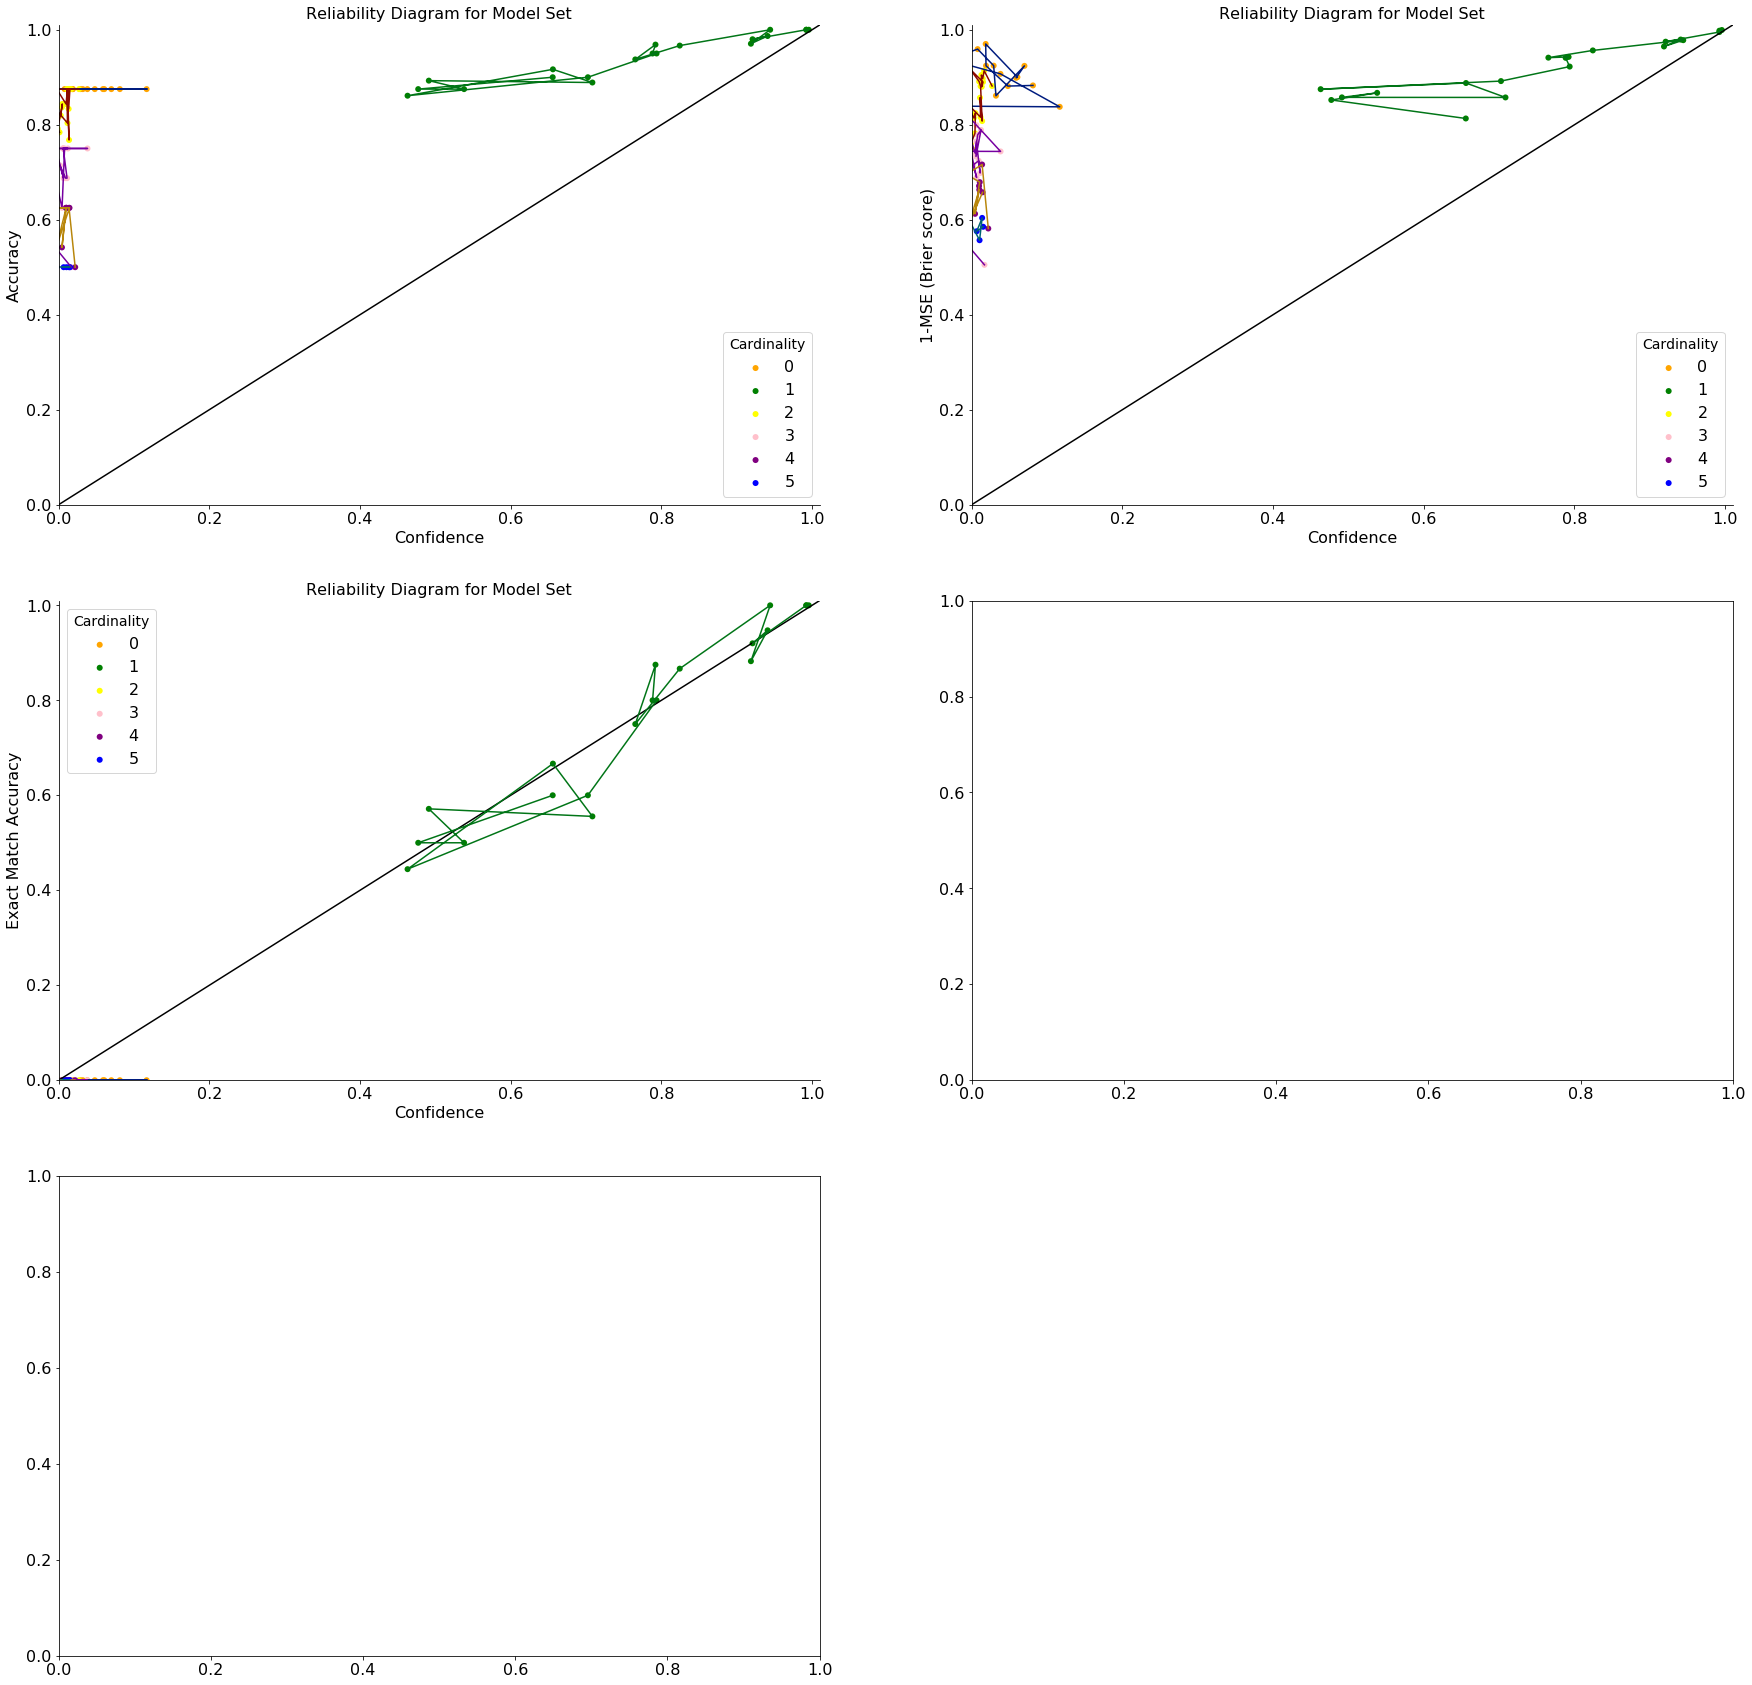

In [608]:
to_calibrate_x = global_pos_validation_df[ y_actual_list ]
to_calibrate_y_actual = global_pos_validation_df[['exact_match']]
display(to_calibrate_x.head(2))
display(to_calibrate_y_actual.head(2))
newly_calibrated = clf.predict(to_calibrate_x)
new_df = global_pos_validation_df.copy()
new_df = new_df.drop('set_conf', axis =1)
new_df ['set_conf'] = list(newly_calibrated)
display (new_df.head())
plot_reliability(new_df)

# Lets review some of the co-occuring sentences, set the firist var "label count" to between 2 and 8 to review co-occurances

In [610]:
label_count = 4

# print (thresholds_calab)
print (thresholds_max)

# # used this to validate the calculations.
# #print(metrics.classification_report(y_actual, y_pred, digits=3))
view_co_occur = widgets.SelectMultiple(
     options=thresholds_calab,
     #rows=10,
     description='select co-occurences to view',
     disabled=False,
     style = my_style,
     layout = my_layout
 )

# output_review_txt = widgets.Output()
# def view_co_occurances():
#     return


# row_to_edit = convention_sentences_df.loc[(convention_sentences_df[convention_drop_down_value] == 1) &
#                                             (convention_sentences_df['data_provenance'] == source_drop_down_value) &
#                                             (convention_sentences_df['confidence_value'] >= filter_lower) &
#                                             (convention_sentences_df['confidence_value'] <= filter_upper)].sample(n = 1)

display (global_pos_validation_df.shape[0])

temp = global_pos_validation_df.loc[(global_pos_validation_df['lbl_cnt'] == label_count)]
for x in range (20):
    print ("Text to be classified:")
    display (temp.iloc[x][0])
    print ("The actual conventions:")
    for k in thresholds_calab:
        if temp.iloc[x][k] == 1:
            print (k+" actual",temp.iloc[x][k])
            print (k+" predicted",temp.iloc[x][k+"_y_pred"])
            print (k+" probability",temp.iloc[x][k+"_prob"])
    print ("")
    print ("The false positives conventions:")
    for k in thresholds_calab:
        if temp.iloc[x][k+"_y_pred"] == 1 and temp.iloc[x][k] == 0:
            #print (k+" actual",temp.iloc[x][k])
            print (k+" predicted",temp.iloc[x][k+"_y_pred"])
            print (k+" probability",temp.iloc[x][k+"_prob"])
       
    print ("############") 
    print ("")


{'civic': 0.4, 'domestic': 0.7, 'green': 0.4, 'industrial': 0.7, 'inspired': 0.6, 'market': 0.7, 'project': 0.6, 'renown': 0.7}


543

Text to be classified:


'May Day Festivals of Flirtation Fertility and Sexual FrenzyThis May Day let us pay tribute to the Earth Mother and Her daughter goddesses of green growth by planting May trees and flowers and then dancing around them to celebrate the lovely lusty miracle of life.'

The actual conventions:
green actual 1
green predicted 1
green probability 1.0

The false positives conventions:
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.6666666666666666
renown predicted 1
renown probability 1.0
############

Text to be classified:


'according to this logic there are beings even worthier than artists beings who inhabit magical worlds (shades fairies magi) but when these are evoked in the work we are drawing on here it is always in a desecratory mode.'

The actual conventions:
inspired actual 1
inspired predicted 1
inspired probability 1.0

The false positives conventions:
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.8181818181818182
renown predicted 1
renown probability 0.8571428571428571
############

Text to be classified:


'at ease where he finds himself he also knows how to be local.'

The actual conventions:
project actual 1
project predicted 1
project probability 0.8181818181818182

The false positives conventions:
civic predicted 1
civic probability 0.49468198236994987
domestic predicted 1
domestic probability 0.9333333333333333
market predicted 1
market probability 0.8571428571428571
############

Text to be classified:


'but the very existence of such collective beings which have no bodies of their own can easily be challenged: only individuals truly exist.'

The actual conventions:
civic actual 1
civic predicted 1
civic probability 0.9629629629629629

The false positives conventions:
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.6666666666666666
renown predicted 1
renown probability 0.8571428571428571
############

Text to be classified:


'for example rafting companies active in fighting the dam had their guides talk to the customers about the dispute and (when they felt they had convinced them) ask them to write letters to their representatives and to ferc.'

The actual conventions:
renown actual 1
renown predicted 1
renown probability 0.8571428571428571

The false positives conventions:
civic predicted 1
civic probability 0.9629629629629629
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.8613979627678258
############

Text to be classified:


'from here what you do is only limited by your imagination but here are a few ideas to get started:'

The actual conventions:
inspired actual 1
inspired predicted 1
inspired probability 1.0

The false positives conventions:
civic predicted 1
civic probability 0.8
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.7777777777777778
############

Text to be classified:


'help support spyder the community developed scientific ide!'

The actual conventions:
civic actual 1
civic predicted 1
civic probability 0.9629629629629629

The false positives conventions:
green predicted 1
green probability 0.8125
industrial predicted 1
industrial probability 0.972972972972973
project predicted 1
project probability 0.7777777777777778
############

Text to be classified:


'i need professional support with conversations or setting up my server'

The actual conventions:
industrial actual 1
industrial predicted 1
industrial probability 0.8125

The false positives conventions:
civic predicted 1
civic probability 0.8
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.7777777777777778
############

Text to be classified:


'if a good caller meets its obligations the onus is thus on you to fulfill your end of the bargain.'

The actual conventions:
market actual 1
market predicted 1
market probability 0.8571428571428571

The false positives conventions:
civic predicted 1
civic probability 0.9629629629629629
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.6666666666666666
############

Text to be classified:


"in a hierarchical order judgment belongs to the most worthy person who must thus not be kept in the dark about anything so that she can issue an informed ruling: don't let the leader remain unaware of the problems about which she should normally be informed...."

The actual conventions:
domestic actual 1
domestic predicted 1
domestic probability 0.9333333333333333

The false positives conventions:
market predicted 1
market probability 0.8571428571428571
project predicted 1
project probability 0.8333333333333334
renown predicted 1
renown probability 0.8571428571428571
############

Text to be classified:


'in france the notion of a sublime and wild nature is commonly found in the somport dispute as in the clavey dispute. if you touch the aspe valley if you want to make it more accessible if you give it over to concrete and trucks it would be a crime against beauty an acid facelift of the noble visage of a distinguished old lady.'

The actual conventions:
green actual 1
green predicted 0
green probability 0.9333333333333333

The false positives conventions:
civic predicted 1
civic probability 0.8
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.8181818181818182
renown predicted 1
renown probability 1.0
############

Text to be classified:


'it confers on them a right of presence and a right to vote prerogatives that are attested by cards contributions and receipts: the receipt for contributions on which the collector records the sums received.'

The actual conventions:
civic actual 1
civic predicted 1
civic probability 0.9629629629629629

The false positives conventions:
market predicted 1
market probability 0.8571428571428571
project predicted 1
project probability 0.6666666666666666
renown predicted 1
renown probability 1.0
############

Text to be classified:


"objects and arrangements are thus the means by which beings recognize one another's worth just as they know their own this is the way they know and deploy the relative worth of the persons involved and also the way they make themselves known."

The actual conventions:
domestic actual 1
domestic predicted 1
domestic probability 0.9333333333333333

The false positives conventions:
civic predicted 1
civic probability 0.9206763965746954
project predicted 1
project probability 0.8333333333333334
renown predicted 1
renown probability 0.9146508981865211
############

Text to be classified:


'people refer to the clavey canyon as a special place evoking personal tranquility and they talk about the transformative feeling of being a mere human in the rugged wilderness of the area.'

The actual conventions:
inspired actual 1
inspired predicted 1
inspired probability 0.8333333333333334

The false positives conventions:
civic predicted 1
civic probability 0.9629629629629629
project predicted 1
project probability 0.7777777777777778
renown predicted 1
renown probability 0.8571428571428571
############

Text to be classified:


'reference to this world is made nonetheless each time people attain worth without bothering about opinions of others.'

The actual conventions:
inspired actual 1
inspired predicted 0
inspired probability 0.7692307692307692

The false positives conventions:
domestic predicted 1
domestic probability 0.9333333333333333
market predicted 1
market probability 1.0
project predicted 1
project probability 0.7777777777777778
renown predicted 1
renown probability 1.0
############

Text to be classified:


'the objects that circulate flowers or gifts right down to the smallest courtesy toward others indicate by their direction the relative worth of the persons among whom they are exchanged.'

The actual conventions:
domestic actual 1
domestic predicted 1
domestic probability 0.9333333333333333

The false positives conventions:
civic predicted 1
civic probability 0.9629629629629629
project predicted 1
project probability 0.6666666666666666
renown predicted 1
renown probability 1.0
############

Text to be classified:


'the opportunism that characterizes the worthy those who know how to make the most of everything in the market world thus goes hand in hand unparadoxically with a certain attention to others that presupposes the ability to listen really to hear what someone is saying (mccormack ) (inasmuch as others are detached individuals themselves and not inasmuch as they form an opinion from which one has to protect oneself like the others in the world of fame).'

The actual conventions:
market actual 1
market predicted 0
market probability 0.3913043478260869

The false positives conventions:
civic predicted 1
civic probability 0.9409948948764076
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.8181818181818182
renown predicted 1
renown probability 1.0
############

Text to be classified:


"thus a collective workers' organization is open to all workers whatever their political or philosophical opinions nationality age or sex."

The actual conventions:
civic actual 1
civic predicted 1
civic probability 1.0

The false positives conventions:
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.7777777777777778
renown predicted 1
renown probability 1.0
############

Text to be classified:


'when they face superiors beings worthy of esteem are deferential which does not however imply obsequiousness opportunism or flattery.'

The actual conventions:
domestic actual 1
domestic predicted 1
domestic probability 1.0

The false positives conventions:
civic predicted 1
civic probability 0.9629629629629629
project predicted 1
project probability 0.7777777777777778
renown predicted 1
renown probability 1.0
############

Text to be classified:


"yourself or pay someone to do it if you think it's worth the effort."

The actual conventions:
market actual 1
market predicted 1
market probability 1.0

The false positives conventions:
civic predicted 1
civic probability 0.8
domestic predicted 1
domestic probability 0.9333333333333333
project predicted 1
project probability 0.8181818181818182
############



# Evaluation Metrics for over all asystem (I need to modify this)
In multi-label classification, a misclassification is no longer a hard wrong or right. 
A prediction containing a subset of the actual classes should be considered 
better than a prediction that contains none of them, i.e., predicting two 
of the three labels correctly is better than predicting no labels at all. The following metrics can be used
   * Micro-averaging & Macro-averaging (Label based measures):
   * Hamming-Loss (Example based measure):
   * Exact Match Ratio (Subset accuracy):
   * Mean column-wise ROC AUC (average of the individual AUCs of each predicted column)


In [ ]:
numbers = [dict_roc_auc[key] for key in dict_roc_auc]
mean_auc = statistics.mean(numbers)
numbers = [dict_log_loss[key] for key in dict_log_loss]
mean_log_loss = statistics.mean(numbers)
print ("* Mean column-wise ROC AUC for set of models ", mean_auc)
print ("* Mean Log Loss for set of models", mean_log_loss )
print ("")
print ("* Macro average precision", "TBD" )
print ("* Macro average recall", "TBD" )
print ("* Macro average F1", "TBD" )
micro_average_max = pd.DataFrame(threshold_best_all.iloc[threshold_best_all.shape[0]-1])
micro_average = pd.DataFrame(threshold_t_calab_all.iloc[threshold_t_calab_all.shape[0]-1])
print ("")
print ("Micro averages using T-calab with metric")
display (micro_average)
print ("")
print ("Micro averages using max value of metric")
display (micro_average_max)


In [ ]:
#AF: not sure what is the purpose of this, ie why are we training the models again?
def train_models_and_get_scores(df, t_calibration, N_executions=1):
    accs = {}
    precs = {}
    AUCs = {}
    for i in tqdm.tqdm(range(N_executions)):
    
        _DLModels, _DLTokenizers, _DLData_val_x, _DLData_val_y, _DLTrain_histories = model_helpers.train_DL_models(df,
                    data_class_column="convention", 
                    data_label_column="label",
                    tokenizer=extended_tokenizer,
                    random_seed=0,
                    use_validation=True) 

        for k in _DLModels.keys():
            model = _DLModels[k]
            x_val = _DLData_val_x[k]
            y_val = _DLData_val_y[k][:,1]

            pred = model.predict(x_val)[:,1]
            y_pred = apply_pred_threshold(pred, t_calibration)



            if k in accs:
                accs[k].append(accuracy_score(y_val, y_pred))
                precs[k].append(precision_score(y_val, y_pred))
                AUCs[k].append(roc_auc_score(y_val, y_pred))
            else:
                accs[k] = [accuracy_score(y_val, y_pred)]
                precs[k] = [precision_score(y_val, y_pred)]
                AUCs[k] = [roc_auc_score(y_val, y_pred)]
        
    return accs, precs, AUCs

#AF: not sure what is the purpose of this, ie why are we training the models again? commenting out for now:

# accs, precs, AUCs = train_models_and_get_scores(training_df, equalized_precisions_threshold)
# print("Models performance on unseen data:\n\n")
# custom_ordered_keys = ["industrial", "project", "market", "inspired", "civic", "domestic", "green", "renown"]
# for k in custom_ordered_keys:
#     avg_acc = "%.3f" % np.mean(accs[k])
#     avg_auc = "%.3f" % np.mean(AUCs[k])
#     avg_prec = "%.3f" % np.mean(precs[k])
    
#     print("{} & {}  & {} & {}\\".format(k, avg_acc, avg_prec, avg_auc))
#     print("\hline")


#this method is called once per convention with the combined responses of all used as input to
#plot the confusion matrix. The difference between this method and the AF method is that here only 
#the validation data that has true label of 1 is being used, as opposed to blindly using the data and 
#plotting a confusion matrix of the predicted_y = 1. in other words this does not consider any entry 
#in the validation set where for example convention A gives a prediction of 1 when in reality the real label is 0.
#i think this may be a bug?
def compute_confusions(conv, models_, data_x, data_y, calibration_threshold=0.656):
    global classifier_thresholds
    #create a list with  a value for each convention(initially set to 0).
    matches = [0] * len(classifier_thresholds.keys())
 
    #for convention = conv we will get a list of sentences from the validation data for ground truth label = True(1)
    sentences = data_x[conv][np.argwhere(data_y[conv][:,1]==1)]
    shape = sentences.shape
    sentences = sentences.reshape(shape[0], shape[2])
    sent_length = len(sentences)
    
    #iterate through conventions and a value between 0 and len(list "matches")
    for k, idx in zip(classifier_thresholds.keys(), range(len(matches))):
        print(sentences.shape)
        pred = models_[k].predict(sentences, verbose=0)
        pred = np.array(pred)
        matches[idx] = (pred[pred[:,1]> classifier_thresholds[k]]).sum()
    
        
    return matches, sent_length

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          class_lengths = None):
    
    #print(cm)
    if normalize:
        if class_lengths:
            cm = cm.astype('float') / np.array(class_lengths)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    print(np.sum(cm[:,1]))
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
        else:
            title = 'Confusion matrix, without normalization \n Accuracy: "%.5f"' % np.mean(cm.diagonal()) 
            
    classes = [c.capitalize() for c in classes]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_ylim(cm.shape[0]-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    
    #thresh = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    #color=cm[i,j])
                    color="white" if cm[i, j] > thresh else "black")
    
    #fig.tight_layout()
    return ax
y_true = []
y_pred = []

conf_matrix = []
class_lengths = []


for conv in classifier_thresholds.keys():
    print(" -- {}     ".format(conv))
    matches, cl_len = compute_confusions(conv, _DLModels, _DLData_val_x, _DLData_val_y)
    conf_matrix.append(matches)
    class_lengths.append(cl_len)
    
conf_matrix = np.array(conf_matrix)
class_names = list(classifier_thresholds.keys())
print (class_names)
plot_confusion_matrix(conf_matrix, class_names, normalize=True, class_lengths = class_lengths)
display(conf_matrix)

## Matches histograms

In [ ]:
def plot_matches_histogram_multiclass(_matches, _models, title=None, data_sources=[]):

    f, ax = plt.subplots(figsize=[12,6])
    
    elems = [k.replace("training_", "").replace(".txt", "").capitalize()  for k in list(_models.keys())]

    
    barWidth = 0.25  # the width of the bars
    # Set position of bar on X axis
    r1 = np.arange(len(elems))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    rs = [r1,r2,r3]


    
    for m_idx, m in enumerate(_matches):
        f = np.array(m).sum(axis=0)
        f = f / np.sum(f)
        
        print(f)
        print(r1)

        plt.bar(rs[m_idx], f, width=barWidth, edgecolor='white', label=data_sources[m_idx])
        
    # Add xticks on the middle of the group bars
    plt.xlabel('Conventions', fontweight='bold')
    plt.ylabel('Percentage', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(elems))], elems)
    plt.legend()
    plt.show()

In [ ]:
def get_model_matches(sequences, model):
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    preds = model.predict(data)

    return preds

def count_positive_preds(preds):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>preds[j][0])
    return count

def count_positive_preds_with_threshold(preds, threshold=0.5):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>=threshold)
    return count

def calculate_matches(repositories_descriptions, _models, _tokenizers, model_preds_func=count_positive_preds, threshold=None):
    _repos_matches = []

    ##Â Counting number of matches per model for each repo
    for r_description in repositories_descriptions:
        r_description = r_description.split("\n")

        this_repo_matches = []
        for model_key in _models.keys():
            matches=0

            tokenized_r_description = _tokenizers[model_key].texts_to_sequences(r_description)

            preds = get_model_matches(tokenized_r_description, _models[model_key])

            if threshold is None:
                num_matches = model_preds_func(preds)
            else:
                num_matches = model_preds_func(preds, threshold)

            this_repo_matches.append(num_matches)

        _repos_matches.append(this_repo_matches)
        
    return _repos_matches

# Analyzing the Github and Semantic Scholar data

In [ ]:
AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_AI_repos_dump.csv", sep=";")
not_AI_repos = pd.read_csv("Data/ToBeAnalyzed/github_non_AI_repos_dump.csv")

In [ ]:
not_AI_repos.head()

In [ ]:
MAX_SEQUENCE_LENGTH=32

In [ ]:
AI_texts = AI_repos['cleaned_descriptions'].values

#AI_texts =[t.split("\n") for t in AI_texts]
AI_repos_matches = calculate_matches(AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!



In [ ]:
not_AI_texts = not_AI_repos['cleaned_descriptions'].values
not_AI_repos_matches = calculate_matches(not_AI_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!



In [ ]:
S2_texts = []
with open("Data/ToBeAnalyzed/s2_random_3345_nn.txt", "rb") as f:
    S2_texts = f.readlines()
    f.close()
S2_texts = [str(s) for s in S2_texts]
    
S2_matches = calculate_matches(S2_texts, 
                                     models[0][0], 
                                    models[0][1],
                                    model_preds_func=count_positive_preds_with_threshold, 
                                    threshold = 0.656) ##As obtained above!




In [ ]:
data_sources = ['AI repositories', 'Not AI repositories', 'AI scientific articles']
plot_matches_histogram_multiclass([AI_repos_matches, not_AI_repos_matches, S2_matches], models[0][0], "Conventions for not AI research articles", data_sources)

In [ ]:
print(len(AI_repos))
print(len(not_AI_repos))okay

In [ ]:
ai_sents = []
for t in AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        ai_sents.append(str(term))
len(ai_sents)

In [ ]:
not_ai_sents = []
for t in not_AI_repos['cleaned_descriptions'].values:
    for term in t.split("\n"):
        not_ai_sents.append(str(term))
len(not_ai_sents)

In [ ]:
AI_repos['repo_num_stars'].hist(bins=50)

In [ ]:
np.mean(AI_repos['repo_num_stars'])

In [ ]:
np.mean(not_AI_repos['repo_num_stars'])

In [ ]:
np.max(AI_repos['repo_num_stars'])

In [ ]:
np.mean(AI_repos['repo_num_stars'])

In [ ]:
AI_repos.head()

In [ ]:
AI_repos['repo_language'].mode()

In [ ]:
not_AI_repos['repo_language'].mode()

In [ ]:
len(AI_repos[AI_repos['repo_language'] == 'Python']) / len(AI_repos)

In [ ]:
len(not_AI_repos[not_AI_repos['repo_language'] == 'JavaScript']) / len(not_AI_repos)

# Get a list of keywords per convention from the Training data

In [ ]:
#Read the combined original training data and audited data file from "training_ALL.tsv"
#Note this method already calls "remove_line_breaks"
USE_GIT_HUB = True

print (paths.TRAINING_DATA_ALL_DIR_FILE_GIT)
print (paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL)

#Note this method already calls "remove_line_breaks"
training_df = model_helpers.get_training_data(
                            USE_GIT_HUB,
                            paths.TRAINING_DATA_ALL_DIR_FILE_GIT,
                            paths.TRAINING_DATA_ALL_DIR_FILE_LOCAL, 
                            paths.GIT_OWNER,
                            paths.GIT_REPO)

display (training_df.head())

for c in training_df['convention'].unique():
    print(c)
    print("number of sentences", len(training_df[training_df['convention'] == c]))
    print("number of sentences in class 1",len(training_df[ (training_df['convention'] == c) & (training_df['label'] == 1)]))
    print()

In [ ]:
#AF: fixed bug here, to generate the keywords we must use only the data from training data where label = 1
custom_ordered_keys = ["industrial", "project", "market", "inspired", "civic", "domestic", "green", "renown"]
docs = []

for c in custom_ordered_keys:
    #docs.append("\n".join(list(training_df[training_df['convention'] == c]['text'].values)))
    docs.append("\n".join(list(training_df[ (training_df['convention'] == c) & (training_df['label'] == 1)]['text'].values)))

In [ ]:
#AF: https://gist.github.com/sebleier/554280, added additional stop words here, need to add them to the file.
stopwords = parsing_helpers.get_stop_words(paths.STOP_WORDS_DIR_FILE_LOCAL)
stopwords = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]

In [ ]:
#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)
print (cv)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

MIN_TFIDF_SCORE = 0.05

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10, min_score=MIN_TFIDF_SCORE):
    """get the feature names and tf-idf score of top n items"""
    #use only items with > min score
    sorted_items = [[idx, score] for idx,score in sorted_items if score>=min_score]
    
    #return only top n items
    if len(sorted_items) > topn:
        sorted_items = sorted_items[:topn]
        
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [ ]:
# you only needs to do this once
feature_names=cv.get_feature_names()


# get the document that we want to extract keywords from
for doc_idx, doc in enumerate(docs):
    print("=====================================")
    print("         {}                   ".format(custom_ordered_keys[doc_idx]))
    print("=====================================")
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 30
    keywords=extract_topn_from_vector(feature_names, sorted_items, 30, MIN_TFIDF_SCORE)
    print(keywords)
          

display (HTML("<font color = green><h3><left>***Top 5 Keywords from training data for paper Results***</left></h3></font>"))
for doc_idx, doc in enumerate(docs):
    print("=====================================")
    print("         {}                   ".format(custom_ordered_keys[doc_idx]))
    print("=====================================")
    

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    
    #Extract the top 5 for the paper Results
    keywords=extract_topn_from_vector(feature_names,sorted_items, 5, MIN_TFIDF_SCORE)
    print(keywords)
       

In [ ]:
# now combine the training data keywords with the domain expert keywords.
keyword_from_social_scientists_dict = {
    'industrial': 
        ['efficiency', 'efficiant', 'performance', 'performances', 'productivity', 'productive', 'output', 'outputs', 'control', 'power', 'functionality', 'functional', 'organisation', 'organisations', 'professional', 'professionals', 'profession', 'professions', 'reliability', 'reliable', 'foreseeability', 'qualification', 'qualifications', 'expert', 'experts', 'expertise', 'progress' , 'standard', 'standards', 'standardized', 'norms', 'norm', 'growth', 'quantification', 'quantifiy', 'measurement', 'measure', 'measures', 'engineering', 'engineer', 'forecast', 'linearity', 'extrapolation', 'extrapolate', 'scientific', 'plans', 'plan', 'audit', 'audits', 'benchmark', 'benchmarks', 'benchmarking', 'test', 'tests'],
    'project':
        ['flexibility', 'project', 'projects', 'networking', 'networker', 'networkers', 'activity', 'intermediary', 'mediation', 'switch', 'switching', 'shift', 'shifting', 'mobility', 'dynamic', 'transition', 'transitions', 'temporality', 'fluidity', 'communication', 'communications', 'communicate', 'initiative', 'initiatives', 'bridging', 'adapt', 'adaption', 'adaptions'],
    'market':
        ['wealth', 'money', 'goods', 'rival', 'selfishness', 'winner', 'winners', 'price', 'customer', 'customers', 'customized', 'seller', 'sellers', 'sell', 'vendor', 'vendors', 'buyer', 'buyers', 'buy', 'purchaser', 'purchasers', 'purchase', 'opportunity', 'opportunities', 'competition', 'compete', 'sale', 'sales', 'business', 'interest', 'transaction', 'transactions', 'availability', 'owner', 'owners', 'bargain', 'contract', 'contracts', 'pay', 'deal', 'trade', 'scarcity', 'trading', 'entrepreneur', 'entrepreneurs', 'entrepreneurial', 'market', 'markets', 'marketing', 'marketplace'],
    'inspired':
        ['inspiration', 'illuminated', 'unexpected', 'feeling', 'fascination', 'fascinating', 'thrilling', 'genuineness', 'intuition', 'genius', 'brilliant', 'uniqueness', 'non-conformity', 'non-conform', 'passion', 'passionate', 'creative', 'creativity', 'imagination', 'visionary', 'extraordinary', 'emotional', 'conviction', 'holy', 'gifted', 'blessed'],
    'civic':
        ['collective', 'collectives', 'common good', 'community', 'communities', 'representative', 'representatives', 'general interest', 'unite', 'unity', 'union', 'unions', 'majority', 'civil right', 'civil rights', 'assembly', 'democracy', 'vote', 'votes', 'voting', 'election', 'elections', 'elect', 'equality', 'fair', 'fairness', 'law', 'laws', 'justice', 'unbiased', 'impartial'],
    'domestic':
        ['superior', 'superiority', 'continuity', 'continuation', 'dependence', 'dependency', 'familiarity', 'tradition', 'traditions', 'origins', 'origin', 'routine', 'routines', 'habit', 'habits', 'etiquette', 'common sense', 'respect', 'duty', 'duties', 'trust', 'craft', 'crafts', 'craftsman', 'crafted'],
    'green':
        ['nature', 'ecological', 'ecology', 'renewable', 'recyclable', 'recycle', 'sustainable', 'sustainability', 'preserve', 'preservation', 'holism', 'holistic', 'green', 'emission', 'organic', 'organical'],
    # 'Vitality'
    'renown':
        ['acknowledgement', 'praise', 'public relation', 'public relations', 'public opinion', 'brands', 'brand', 'audience', 'follower', 'followers', 'supporter', 'supporters', 'fame', 'influence', 'influences', 'glory', 'attractive', 'appealing']   
}

# END Keywords

In [ ]:
training_df[training_df['convention'] == 'inspired']

In [ ]:
for c in training_df['convention'].unique():
    print(c)
    print(len(training_df[training_df['convention'] == c]))
    print()

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(epochs=20):
    word_index = extended_tokenizer.word_index
    num_epochs = epochs
    EMBEDDING_DIM=100
    MAX_SEQUENCE_LENGTH=32
    
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)


    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#

    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)

    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model
    
model = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)

In [ ]:
np.linspace(.1, 1.0, 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
training_df['convention'].unique()

In [ ]:
for _conv in training_df['convention'].unique():
    tmp_df_train = training_df[training_df['convention']==_conv]

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))

    X=data
    y=labels

    title = "Learning Curves ({})".format(_conv.capitalize())
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

    plt.show()

In [ ]:
data_portions = np.arange(.1, 1.01, 0.10)
print(data_portions)

accs = []

for p in data_portions:
    
    tmp_df_train = training_df[training_df['convention']=='industrial']

    texts = tmp_df_train['text'].values
    labels = tmp_df_train['label'].values

    sequences = extended_tokenizer.texts_to_sequences(texts)


    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    
    selected_indexes = random.choice(list(enumerate(X)))[0]
    
    tmp_x = data[selected_indexes]
    tmp_y = labels[selected_indexes]
    
    
    
    
    

    title = "Learning Curves (Industrial)"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    #cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

    estimator = KerasClassifier(build_fn=create_model, epochs=20, verbose=0)
    
    
    estimator.train(tmp_x)

    
    accs.append(metrics.accuracy_score())